In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,glob
import seaborn as sns
from open_ephys.analysis import Session

from pynwb import NWBHDF5IO, NWBFile
from pynwb.file import Subject

from datetime import datetime
from dateutil.tz import tzlocal

from jlh_ephys.analysis import Analysis
from jlh_ephys.utils import choose_stim_parameter, OE
from jlh_ephys.psth_raster import psth_arr 
#from jlh_ephys import spatial_tools as st  ## compatability issues maybe need to install from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache in its own env 
from jlh_ephys.raw import find_artifact_start, align_data, raw_heatmap

from ccf_3D.tools import herbs_processing as hp
from ccf_3D.tools.metrics import distance

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from scipy.ndimage import gaussian_filter1d

In [2]:
jlh31 = Analysis('jlh31', '2023-01-24') # all probes, many params and sites
jlh32 = Analysis('jlh32', '2023-02-18') # all probes, many params and sites
jlh33 = Analysis('jlh33', '2023-02-22') # probe B and C, many params and trains in diff recordings
jlh34 = Analysis('jlh34', '2023-05-15') # all 3 many params
jlh39 = Analysis('jlh39', '2023-08-16') # 3 probes for bi, no A for mono
jlh40 = Analysis('jlh40', '2023-08-21') # probeB and probe C only: monopolar -- with diff pulse width
jlh48 = Analysis('jlh48', '2024-11-05') # bb test, sorted only no bb portion (full bi and mono)
jlh49 = Analysis('jlh49v1', '2024-07-11') # bb test, just no bb portion (full bi only)
jlh53 = Analysis('jlh53concat', '2024-09-03') # regular, all 3 probes, probe A broke sometime. 

recordings = [jlh31, jlh32, jlh33, jlh34, jlh39, jlh40, jlh48, jlh49, jlh53]
for r in recordings:
    r.get_brain_regs()
    r.get_electrode_coords()

nn_contacts_labels = [6,11,3,14,1,16,2,15,5,12,4,13,7,10,8,9]

EP_path = r"C:\Users\jordan\Documents\combined_figs\evoked_potentials"

amp_alphas = {5: 0.3, 25: 0.5, 50: 0.7, 100: 1.0}
bipolar_color = '#82A69D'
cathodal_color = '#161943'
anodal_color = '#D99551'

c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB found. Trials and Units loaded


c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded


NWB found. Trials and Units loaded


INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded
INFO:root:Final adjusted brain regions loaded
INFO:root:Final adjusted coordinates loaded


In [3]:
distances = {}
distances_norm = {}

for r in recordings:
    contact = r.trials.contact_negative[0]
    distances[r.mouse] = r.get_dists(contact)
    
    temp_norm_dist = {}
    for probe, dists in r.distances.items():
        # normalize min dist to 0 
        min = np.min(dists)
        dists_norm = dists - min
        # make prior to crossing point negative and after positive
        cross_index = np.where(dists_norm == 0)[0][0]  # this gives the first index where data is non-positive
        dists_norm[cross_index:] = -np.abs(dists_norm[cross_index:])
        temp_norm_dist[probe] = dists_norm

        dists[cross_index:] = -np.abs(dists[cross_index:])
        r.distances[probe] = dists
    
    distances_norm[r.mouse] = temp_norm_dist

# point source modeling (generating a null hypothesis) Figure 2a-b

[np.float64(0.05),
 np.float64(0.11185308848080133),
 np.float64(0.22253756260434054),
 np.float64(0.443906510851419)]

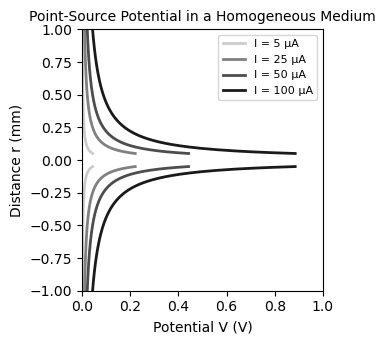

In [166]:
rho = 5.56  
currents_uA = [5, 25, 50, 100] 
currents_A = [i * 1e-6 for i in currents_uA]

# Radial distances (meters)
r_min = 0.5e-4   # 0.05 mm or 50 microns 
r_max = 2e-3     # 1 mm
N_points = 600
r_values = np.linspace(r_min, r_max, N_points)

fig = plt.figure(figsize=(3.54, 3.54))

grays = ['0.8', '0.5', '0.3', '0.1']

half_maxs_dist = [] # duh they're all the same LOL ignore this
full_maxs_dists = []
full_max_threshold = 0.1

for i, I in enumerate(currents_A):
    # Compute potential (in Volts)
    V = (rho * I) / (4 * np.pi * r_values)
    
    # Distance in mm for plotting
    r_mm = r_values * 1e3
    
    hundred_microns = np.abs(r_mm - 0.100).argmin()
    max = V[hundred_microns]
    half_max = max / 2
    half_max_dist = np.abs(V - half_max).argmin()
    half_maxs_dist.append(r_mm[half_max_dist])
    
    full_max_dist = np.abs(V - full_max_threshold).argmin()
    full_maxs_dists.append(r_mm[full_max_dist])
    # Plot: x is potential (V), y is distance (mm)
    label_str = f"I = {I*1e6:.0f} µA"
    plt.plot(V,  r_mm,  linewidth=2, color=grays[i], label=label_str)
    plt.plot(V, -r_mm, linewidth=2, color=grays[i])  # mirror around 0 for ±r

plt.xlabel('Potential V (V)', fontsize=10)
plt.ylabel('Distance r (mm)', fontsize=10)
plt.title('Point-Source Potential in a Homogeneous Medium', fontsize=10)

# Match the original axis ranges: 
# Potential from 0 to 1, distance from -1 mm to 1 mm
plt.xlim(0, 1)
plt.ylim(-1, 1)

plt.legend(fontsize=8)
plt.tight_layout()
save_str = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials\point_source_modeling\potential_vs_distance.png'
#plt.savefig(save_str)

save_str = save_str = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials\point_source_modeling\potential_vs_distance.pdf'
#plt.savefig(save_str)
full_maxs_dists

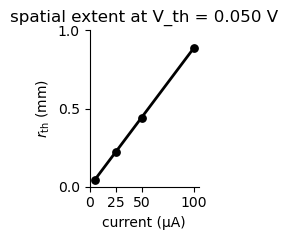

In [46]:
# point-source spatial extent vs current using analytic threshold crossing
rho = 5.56                     # resistivity (Ω·m)
currents_uA = [5, 25, 50, 100] # µA
currents_A = np.array(currents_uA) * 1e-6

V_thresh = 0.05                # volts; "near zero" threshold (try 0.02–0.1)
r_thresh_m = (rho * currents_A) / (4 * np.pi * V_thresh)
r_thresh_mm = r_thresh_m * 1e3

fig, ax = plt.subplots(figsize=(2, 2.5))
ax.plot(currents_uA, r_thresh_mm, '-', lw=2, color = 'k')
ax.scatter(currents_uA, r_thresh_mm, color = 'k', s=28)

ax.set_xlabel('current (µA)')
ax.set_ylabel(r'$r_{\mathrm{th}}$ (mm)')
ax.set_title(f'spatial extent at V_th = {V_thresh:.3f} V')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.set_yticks([0, 0.5, 1.0])
ax.set_xticks([0, 25, 50, 100])
plt.tight_layout()
save_str = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials\point_source_modeling\potential_vs_distance_spatialextent.pdf'
#plt.savefig(save_str)

# algorithm for calculating spatial boundaries of evoked potentials (load data from csv of pre-calculated)

In [ ]:
## note this is will only work if you have raw data which is available upon request 

# thus this is mainly demonstrative -- I provide a curated dataframe of the results where all figures were calculated 

from scipy.ndimage import gaussian_filter1d



pre = -0.3
post = 5 

snapshots = [1]  # ms
snapshot_idxs = [int(pre / 1000 * 30_000) + int(s / 1000 * 30_000) for s in snapshots]
snap_alphas = [1]

data_list = []
for r in recordings:
    for probe in r.probes:
        if r.mouse in ['jlh33', 'jlh40']:  # this fixes the issue with recorded vs geometric probes
            if probe == 'probeB':
                raw_probe = 'probeA'
            elif probe == 'probeC':
                raw_probe = 'probeB'
        else:
            raw_probe = probe
        channels = len(r.probe_coords[probe]) + 20
        
        for run in r.trials.run.unique():
            fig, axs = plt.subplots(1, 2, figsize=(11, 8))
            stim_times = r.trials[r.trials.run == run].start_time.values
            title = f'{probe}_Run{run} {r.parameters[run]}'

            data = r.raw.get_chunk(raw_probe, stim_times, pre=pre + 3, post=post + 3, chs=np.arange(channels))
            try:
                aligned_data = align_data(data, pre, post, channels, threshold=500, median_subtraction=False)
            except:
                print(f'Error in recording {r.mouse} probe {probe} amp {amp}')
                aligned_data = data
            dists = distances[r.mouse][probe]
            sub_chs = np.arange(len(dists), len(dists) + 15)
            aligned_sub_data = aligned_data - np.median(aligned_data[:,:, sub_chs], axis=2)[:,:, np.newaxis]

            # Use the axs object for the current amp
            raw_heatmap(aligned_sub_data, pre=pre, post=post, dists=dists, vmin=-500, vmax=500,
                        save=False, title=f'{r.parameters[run]}', ax=axs[0])
            mean_aligned_sub_data = np.mean(aligned_sub_data, axis=0)
            for snap_idx, (snapshot_time, idx) in enumerate(zip(snapshots, snapshot_idxs)):
                data_snap = aligned_data[:, idx, :]
                data_snap = np.abs(data_snap - np.median(data_snap[:, sub_chs], axis=1)[:, np.newaxis])
                data_snap[:,191] = data_snap[:,192] # ch 191 seems to be the reference?
            
                # algo for slope detection
                smoothed_gauss = gaussian_filter1d(data_snap, sigma=2, axis=1)
                mean_data = np.mean(data_snap, axis=0)
                mean_gauss = np.mean(smoothed_gauss, axis=0)
                sd_gauss = np.std(smoothed_gauss, axis=0)
                baseline_mean = np.mean(mean_gauss[-15:])
                baseline_std = np.std(mean_gauss[-15:])

                
                max_idx = np.argmax(mean_gauss[30:])+30
                max_volt = mean_gauss[max_idx] 
                
                max_threshold = 40
                min_voltage = 20
                half_max = max_volt / 2
                
                if max_volt > max_threshold:
                    uppers = mean_gauss[max_idx:]
                    lowers = mean_gauss[:max_idx] # doesn't allow bottom 30 channels to be considered
                    
                    upper_chs_outside_potential = np.where(uppers < min_voltage)[0]
                    if len(upper_chs_outside_potential) > 0:  
                        upper_bound = (upper_chs_outside_potential[0] - 2) + max_idx #minus two to get channel safely within range
                        half_max_upper = np.where(uppers > half_max)[0][-1] + max_idx
                    else:
                        upper_bound = -1
                        half_max_upper = -1
                    
                    lower_chs_outside_potential = np.where(lowers < min_voltage)[0]
                    if len(lower_chs_outside_potential) > 0:
                        lower_bound = lower_chs_outside_potential[-1] + 2 #plus 2 to get channel safely within range
                        half_max_lower = np.where(lowers < half_max)[0][-1]
                    else:
                        lower_bound = -1
                        half_max_lower = -1
 
                
                else:
                    lower_bound, upper_bound = -1,-1

                axs[1].plot(mean_data, np.arange(0,channels), color='k', label='Raw Mean')
                axs[1].plot(mean_gauss, np.arange(0,channels), color='blue', label='Gaussian Mean')
                axs[1].fill_betweenx(np.arange(0,channels), mean_gauss - sd_gauss, mean_gauss + sd_gauss, color='blue', alpha=0.3, label='SD')
                
                axs[1].set_ylabel('Channel')
                axs[1].set_xlabel('Voltage')
                axs[1].set_title('snapshots')
                axs[1].set_yticks(np.arange(0,channels,10))
                axs[1].legend()

                
                if max_volt > max_threshold:
                    axs[1].axhline(lower_bound, color='cyan', linestyle='--', label='Slope Lower Bound')
                    axs[1].axhline(upper_bound, color='cyan', linestyle='--', label='Slope Upper Bound')
                    axs[1].axhline(half_max_lower, color = 'orange', linestyle = '--', label = 'Half Max Lower')
                    axs[1].axhline(half_max_upper, color = 'orange', linestyle = '--', label = 'Half Max Upper')
                    axs[1].axhline(max_idx, color='black', linestyle='--', label='Max')
                    
                    axs[0].axhline(lower_bound, color='cyan', linestyle='--')
                    axs[0].axhline(upper_bound, color='cyan', linestyle='--')
                    axs[0].axhline(half_max_lower, color = 'orange', linestyle = '--')
                    axs[0].axhline(half_max_upper, color = 'orange', linestyle = '--',)
                    axs[0].axhline(max_idx, color='black', linestyle='--')

            fig.suptitle(title, size=20)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            base_path = os.path.join(EP_path, "ap_potential_w_voltageline")
            sub_folder = os.path.join(base_path, "all_runs_med_sub_spatialdetection", 'abs_volt_threshold_from_max40_min20_halfmax_sigma3', '1ms', r.mouse)
            if not os.path.exists(sub_folder):
                os.makedirs(sub_folder)
            #plt.savefig(os.path.join(sub_folder, f'{r.mouse}_{probe}_run{run}.pdf'))
            #plt.savefig(os.path.join(sub_folder, f'{r.mouse}_{probe}_run{run}.png'))
            plt.close()
            
            # Append all relevant details to the list
            data_list.append({
                    'recording': r.mouse,
                    'probe': probe,
                    'run': run,
                    'stim_parameters': r.parameters[run],
                    'max_idx': max_idx,
                    'max_volt': max_volt,
                    'half_max': half_max,
                    'half_max_upper_idx': half_max_upper,
                    'half_max_lower_idx': half_max_lower,
                    'lower_bound_idx': lower_bound,
                    'upper_bound_idx': upper_bound,
                    'mean_gauss': mean_gauss.tolist(),
                    'std_gauss': sd_gauss.tolist(),
                    'mean_aligned_sub_data': mean_aligned_sub_data 
                })

# Convert the list to a dataframe
df_results_w_array = pd.DataFrame(data_list)

confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming stream name: ProbeA-AP
confirming str

In [4]:
# load the results from the EP boundaries algorithm with some intermediaries 
import pickle

df_results = pd.read_pickle(os.path.join('intermediates', 'EP_boundaries_w_array_distances_curated.pkl'))


recording_names = ['jlh31', 'jlh32', 'jlh33', 'jlh34', 'jlh39', 'jlh40', 'jlh48', 'jlh49v1', 'jlh53concat']
recordings = [jlh31, jlh32, jlh33, jlh34, jlh39, jlh40, jlh48, jlh49, jlh53]

# Create the recording map
recording_map = {name: recording for name, recording in zip(recording_names, recordings)}

with open(r'intermediates\mean_aligned_sub_data.pkl', 'rb') as f:
    array_list = pickle.load(f)

df_results['mean_aligned_sub_data'] = array_list

# average EP heatmaps (Figure 2 e)

C:\Users\jordan\AppData\Local\Temp\ipykernel_65120\3758397808.py:87: RuntimeWarning: Mean of empty slice
  data_to_plot = np.nanmean(combined_array, axis=0).T
C:\Users\jordan\AppData\Local\Temp\ipykernel_65120\3758397808.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(-100, 101, 50))
C:\Users\jordan\AppData\Local\Temp\ipykernel_65120\3758397808.py:87: RuntimeWarning: Mean of empty slice
  data_to_plot = np.nanmean(combined_array, axis=0).T
C:\Users\jordan\AppData\Local\Temp\ipykernel_65120\3758397808.py:87: RuntimeWarning: Mean of empty slice
  data_to_plot = np.nanmean(combined_array, axis=0).T
C:\Users\jordan\AppData\Local\Temp\ipykernel_65120\3758397808.py:87: RuntimeWarning: Mean of empty slice
  data_to_plot = np.nanmean(combined_array, axis=0).T
C:\Users\jordan\AppData\Local\Temp\ipykernel_65120\3758397808.py:87: RuntimeWarning: Mean of empty slice
  data_to_plot

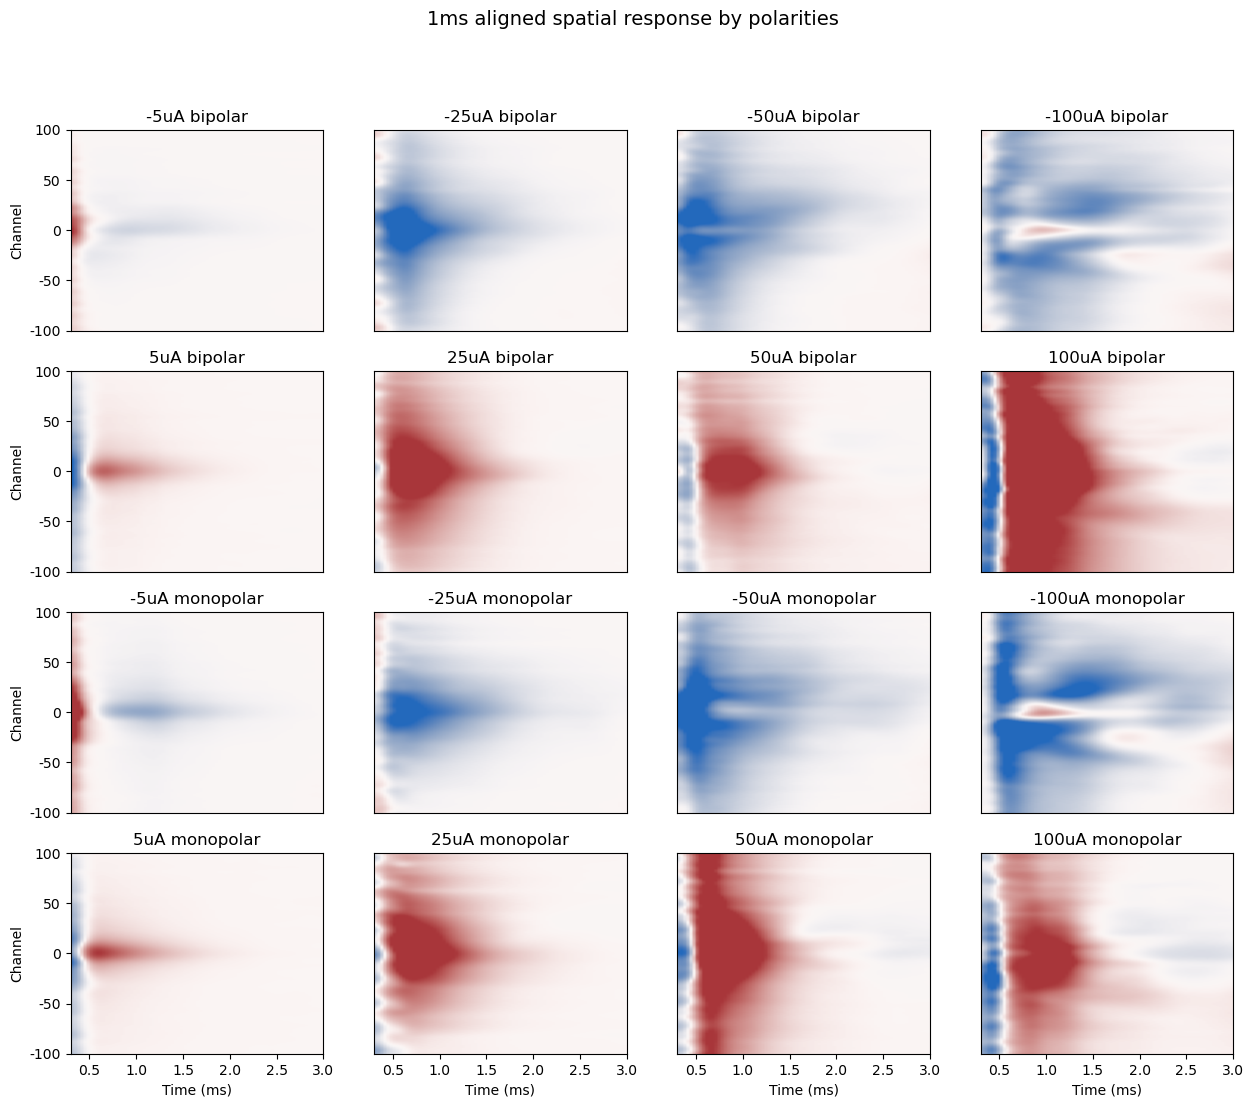

In [5]:
# note, requires raw data to run this code, which is available upon request 
from scipy.ndimage import gaussian_filter

# average fields by polarity and amplitude
polarities = ['bipolar', 'monopolar']

fig, axs = plt.subplots(4, 4, figsize=(15, 12))  # 3 rows (probes), 4 columns (amplitudes)
fig.suptitle(f'1ms aligned spatial response by polarities', fontsize=14)

probes = ['probeA', 'probeB', 'probeC']
amps = [-5, -25, -50, -100, 5, 25, 50, 100]
pad = 400

mean_array_bycondition = {}


pre = -0.3
post = 5 

df_results_w_array = df_results.copy()
for polarity in polarities:
    for i, amp in enumerate(amps):
        if amp < 0 and polarity == 'bipolar':
            row = 0
        elif amp > 0 and polarity == 'bipolar':
            row = 1
        elif amp < 0 and polarity == 'monopolar':
            row = 2
        elif amp > 0 and polarity == 'monopolar':
            row = 3
        
        if np.abs(amp) == 5:
            col = 0
        elif np.abs(amp) == 25:
            col = 1
        elif np.abs(amp) == 50:
            col = 2
        elif np.abs(amp) == 100:
            col = 3
        ax = axs[row, col]
        
        # Filter data for the current probe and amplitude
        df = df_results_w_array[
            (df_results_w_array['max_volt'] > 40) & 
            (df_results_w_array['amplitude'] == amp) & 
            (df_results_w_array['polarity'] == polarity) &
            (df_results_w_array['half_max_lower_idx'] != -1) &
            (df_results_w_array['half_max_upper_idx'] != -1) &
            (df_results_w_array['lower_bound_idx'] != -1) &
            (df_results_w_array['upper_bound_idx'] != -1)
        ].reset_index()

        # Check if the dataframe is empty
        if df.empty:
            ax.set_title(f'{amp}uA {probe} (No Data)')
            ax.axis('off')
            continue
        
        combined_array = np.zeros((len(df), df.iloc[0]['mean_aligned_sub_data'].shape[0], 800)) #800 for padded
        
        for _, dfrow in df.iterrows():
            array = dfrow['mean_aligned_sub_data']
            gauss_array = gaussian_filter1d(array, sigma=1, axis=1)
            
            ## pad it
            max_idx = dfrow['max_idx']
            upper_gauss = gauss_array[:, max_idx:]
            lower_gauss = gauss_array[:, :max_idx]
            
            if upper_gauss.shape[1] < pad:
                upper_pad = [np.nan] * (pad - upper_gauss.shape[1])
                padded_upper_gauss = np.zeros((upper_gauss.shape[0], pad))
                for i in range(upper_gauss.shape[0]):
                    padded_upper_gauss[i] = np.concatenate([upper_gauss[i], upper_pad])
            
            if lower_gauss.shape[1] < pad:
                lower_pad = [np.nan] * (pad - lower_gauss.shape[1])
                padded_lower_gauss = np.zeros((lower_gauss.shape[0], pad))
                for i in range(lower_gauss.shape[0]):
                    padded_lower_gauss[i] = np.concatenate([lower_pad, lower_gauss[i]])
            
            padded_gauss = np.concatenate([padded_lower_gauss, padded_upper_gauss], axis=1)

            combined_array[_, :, :] = padded_gauss

        mean_array_bycondition[f'{polarity}_{amp}'] = combined_array #3D n (probe, run, etc) x samples x channels 
        data_to_plot = np.nanmean(combined_array, axis=0).T
        data_to_plot = gaussian_filter(data_to_plot, sigma=2)
        #data_to_plot = gaussian_filter1d(data_to_plot, sigma=2, axis=1)
        #data_to_plot = gaussian_filter1d(data_to_plot, sigma = 2, axis=0)
        time_ms = np.linspace(-pre, post, data_to_plot.shape[0])
        ax.imshow(data_to_plot, aspect='auto', vmax=200, vmin=-200, origin='lower', cmap='vlag',
                extent=[time_ms[0], time_ms[-1], 0, data_to_plot.shape[0]])
        ax.set_ylim(300, 500)
        ax.set_title(f'{amp}uA {polarity}')
        ax.set_xlim(-pre, 3)
        if row == 3:
            ax.set_xlabel('Time (ms)')

        else:
            ax.set_xticks([])
        if col == 0:
            ax.set_ylabel('Channel')
            ax.set_yticklabels(np.arange(-100, 101, 50))
        else:
            ax.set_yticks([])
#path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
#plt.savefig(os.path.join(path, 'avg_heatmaps_by_polarity_amp_mean_smoothed_3ms_100ch_updated.pdf'))
#plt.savefig(os.path.join(path, 'avg_heatmaps_by_polarity_amp_mean_smoothed_3ms_100ch_updated.png'))

# average EP at 1 ms across distances (Figure 2f and Supp)

C:\Users\jordan\AppData\Local\Temp\ipykernel_35744\1003595102.py:51: RuntimeWarning: Mean of empty slice
  mean_aligned_matrix = np.nanmean(aligned_matrix, axis=0)
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jordan\AppData\Local\Temp\ipykernel_35744\1003595102.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'mean_AUC_fullEP': np.trapz(mean_aligned_matrix[lower_bound_idx:upper_bound_idx]),
C:\Users\jordan\AppData\Local\Temp\ipykernel_35744\1003595102.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'mean_AUC_halfEP': np.trapz(mean_aligned_matrix[half_max_lower_idx:half_max_upper_idx])


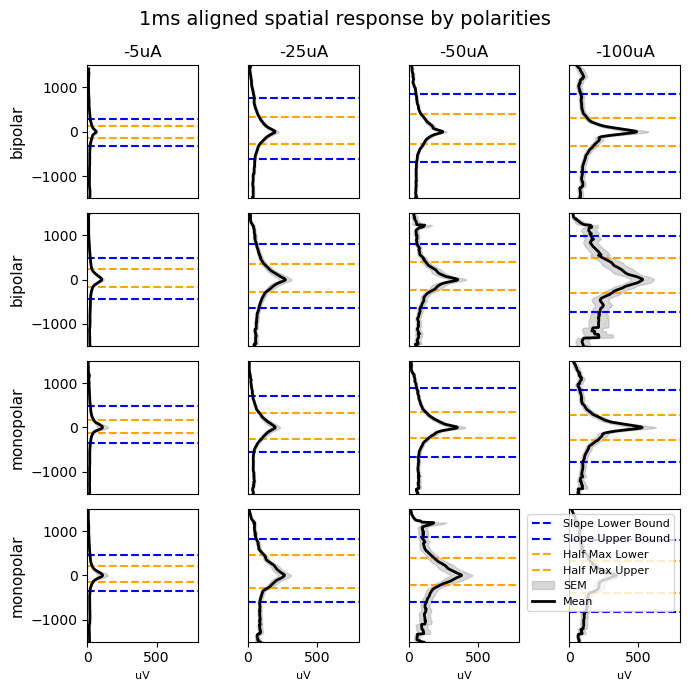

In [22]:
polarities = ['bipolar', 'monopolar']

fig, axs = plt.subplots(4, 4, figsize=(7, 7))  # 3 rows (probes), 4 columns (amplitudes)
fig.suptitle(f'1ms aligned spatial response by polarities', fontsize=14)

probes = ['probeA', 'probeB', 'probeC']
amps = [-5, -25, -50, -100, 5, 25, 50, 100]

mean_boundaries_bycondition = {}

for polarity in polarities:
    for i, amp in enumerate(amps):
        if amp < 0 and polarity == 'bipolar':
            row = 0
        elif amp > 0 and polarity == 'bipolar':
            row = 1
        elif amp < 0 and polarity == 'monopolar':
            row = 2
        elif amp > 0 and polarity == 'monopolar':
            row = 3
        
        if np.abs(amp) == 5:
            col = 0
        elif np.abs(amp) == 25:
            col = 1
        elif np.abs(amp) == 50:
            col = 2
        elif np.abs(amp) == 100:
            col = 3
        ax = axs[row, col]
        
        # Filter data for the current probe and amplitude
        df = df_results[
            (df_results['max_volt'] > 40) & 
            (df_results['amplitude'] == amp) & 
            (df_results['polarity'] == polarity) &
            (df_results['half_max_lower_idx'] != -1) &
            (df_results['half_max_upper_idx'] != -1) &
            (df_results['lower_bound_idx'] != -1) &
            (df_results['upper_bound_idx'] != -1)
        ]

        # Check if the dataframe is empty
        if df.empty:
            ax.set_title(f'{amp}uA {probe} (No Data)')
            ax.axis('off')
            continue

        # Create a matrix of aligned responses
        aligned_matrix = np.array(df['aligned_mean_gauss'].tolist())
        mean_aligned_matrix = np.nanmean(aligned_matrix, axis=0)
        std_aligned_matrix = np.nanstd(aligned_matrix, axis=0)
        sem_aligned_matrix = std_aligned_matrix / np.sqrt(np.sum(~np.isnan(aligned_matrix), axis=0))  # SEM

        normalized_chs = np.arange(-400, 400, 1)
        normalized_distances = np.arange(-4000, 4000, 10)

        upper_bound_idx = int(np.mean(df['upper_bound_idx_aligned'].values))
        lower_bound_idx = int(np.mean(df['lower_bound_idx_aligned'].values))
        half_max_upper_idx = int(np.mean(df['half_max_upper_idx_aligned'].values))
        half_max_lower_idx = int(np.mean(df['half_max_lower_idx_aligned'].values))
        
        mean_boundaries_bycondition[f'{polarity}_{amp}'] = {
            'upper_bound': normalized_distances[upper_bound_idx],
            'lower_bound': normalized_distances[lower_bound_idx],
            'half_max_upper': normalized_distances[half_max_upper_idx],
            'half_max_lower': normalized_distances[half_max_lower_idx],
            'mean_max': mean_aligned_matrix[400],
            'mean_AUC_fullEP': np.trapz(mean_aligned_matrix[lower_bound_idx:upper_bound_idx]),
            'mean_AUC_halfEP': np.trapz(mean_aligned_matrix[half_max_lower_idx:half_max_upper_idx])
        }
        
        
        ax.axhline(normalized_distances[lower_bound_idx], color='blue', linestyle='--', label='Slope Lower Bound')
        ax.axhline(normalized_distances[upper_bound_idx], color='blue', linestyle='--', label='Slope Upper Bound')
        ax.axhline(normalized_distances[half_max_lower_idx], color = 'orange', linestyle = '--', label = 'Half Max Lower')
        ax.axhline(normalized_distances[half_max_upper_idx], color = 'orange', linestyle = '--', label = 'Half Max Upper')
        
        # Plot the SEM error cloud
        ax.fill_betweenx(
            normalized_distances, 
            mean_aligned_matrix - sem_aligned_matrix, 
            mean_aligned_matrix + sem_aligned_matrix, 
            color='gray', alpha=0.3, label='SEM'
        )

        # Plot the mean aligned matrix
        ax.plot(mean_aligned_matrix, normalized_distances, color='black', linewidth=2, label='Mean')

        # Set titles and labels
        
        if row == 0:
            ax.set_title(f'{amp}uA')
        
        if col == 0:
            ax.set_ylabel(f'{polarity}', fontsize=11)
        else:
            ax.set_yticks([])  # Hide y-ticks for all columns except the first
        if row == 3:
            ax.set_xlabel('uV', fontsize=8)
        else:
            ax.set_xticks([])  # Hide x-ticks for all rows except the last

        # Add legend only to the last subplot
        if row == 3 and col == 3:
            ax.legend(loc='upper right', fontsize=8)

        ax.set_xlim([0, 800])
        ax.set_ylim([-1500, 1500])


plt.tight_layout()
path = os.path.join(r'C:\Users\jordan\Documents\combined_figs\evoked_potentials')

#plt.savefig(os.path.join(path, 'spatial_response_by_polarity.png'))
#plt.savefig(os.path.join(path, 'spatial_response_by_polarity.pdf'))



C:\Users\jordan\AppData\Local\Temp\ipykernel_35744\4230350722.py:37: RuntimeWarning: Mean of empty slice
  mean_aligned_matrix = np.nanmean(aligned_matrix, axis=0)


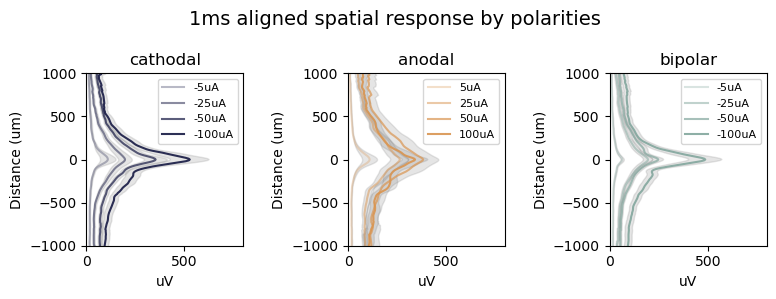

In [ ]:






mean_boundaries_bycondition = {}

fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # 2 rows for polarities, 2 columns for amplitude sign
fig.suptitle('1ms aligned spatial response by polarities', fontsize=12)
colors = [cathodal_color, anodal_color, bipolar_color]
amps = [-5, -25, -50, -100]
for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
    ax = axs[i]    
    if pol == 'bipolar':
        polarity = 'bipolar'
    else:
        polarity = 'monopolar'
    
    for k, amp in enumerate(amps):
        if pol == 'anodal':
            amp = np.abs(amp)  # Make positive for anodal
        
        df = df_results[
            (df_results['max_volt'] > 40) & 
            (df_results['amplitude'] == amp) & 
            (df_results['polarity'] == polarity) &
            (df_results['half_max_lower_idx'] != -1) & 
            (df_results['half_max_upper_idx'] != -1) &
            (df_results['lower_bound_idx'] != -1) & 
            (df_results['upper_bound_idx'] != -1)
        ]

        if df.empty:
            print('skipping empty dataframe for', amp, pol)
            continue  # Skip this iteration if the dataframe is empty
        

        aligned_matrix = np.array(df['aligned_mean_gauss'].tolist())
        mean_aligned_matrix = np.nanmean(aligned_matrix, axis=0)
        sem_aligned_matrix = np.nanstd(aligned_matrix, axis=0) / np.sqrt(np.sum(~np.isnan(aligned_matrix), axis=0))

        normalized_distances = np.arange(-4000, 4000, 10)

        # Plot SEM error cloud
        ax.fill_betweenx(
            normalized_distances, 
            mean_aligned_matrix - sem_aligned_matrix, 
            mean_aligned_matrix + sem_aligned_matrix, 
            color='gray', alpha=0.2   # Use different colors for each amplitude
        )

        # Plot the mean response
        ax.plot(mean_aligned_matrix, normalized_distances, label=f'{amp}uA', color=colors[i], alpha = 0.3 + (k * 0.2))


        ax.set_xlim([0, 800])
        ax.set_ylim([-1000, 1000])
        ax.set_title(f'{pol}')
        ax.set_xlabel('uV')
        ax.set_ylabel('Distance (um)')
        ax.legend(loc='upper right', fontsize=8)

# Adjust layout and save figures
plt.tight_layout()

#path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
#plt.savefig(os.path.join(path, 'spatial_response_by_polarity_and_sign_100ch.png'))
#plt.savefig(os.path.join(path, 'spatial_response_by_polarity_and_sign_100ch.pdf'))



# spatial extents superficial and deep (Figure 2g and Supp CCF vs peak-aligned)

cathodal ccf -5uA: Upper Mean: -424.21, Std: 209.65; Lower Mean: 510.41, Std: 214.59
cathodal ccf -25uA: Upper Mean: -683.18, Std: 252.64; Lower Mean: 591.57, Std: 261.42
cathodal ccf -50uA: Upper Mean: -741.94, Std: 267.22; Lower Mean: 662.26, Std: 263.13
cathodal ccf -100uA: Upper Mean: -743.84, Std: 264.17; Lower Mean: 712.65, Std: 286.44
Linear Fit (Upper): R² = 0.02, Slope = 1.21, Intercept = -684.27, p = 2.10e-01
Quadratic Fit (Upper): R² = 0.10, Coeffs = [ 9.54917872e-02  1.25912366e+01 -4.41297802e+02]
Linear Fit (Lower): R² = 0.16, Slope = -3.84, Intercept = 522.95, p = 1.29e-04
Quadratic Fit (Lower): R² = 0.17, Coeffs = [-2.83744012e-02 -7.22233603e+00  4.50754498e+02]
anodal ccf 5uA: Upper Mean: -395.69, Std: 134.43; Lower Mean: 502.02, Std: 213.57
anodal ccf 25uA: Upper Mean: -649.23, Std: 254.65; Lower Mean: 674.08, Std: 266.56
anodal ccf 50uA: Upper Mean: -679.78, Std: 263.20; Lower Mean: 704.17, Std: 310.94
anodal ccf 100uA: Upper Mean: -705.07, Std: 262.35; Lower Mean: 

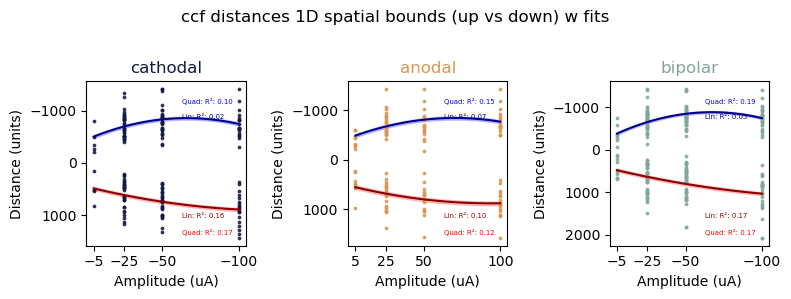

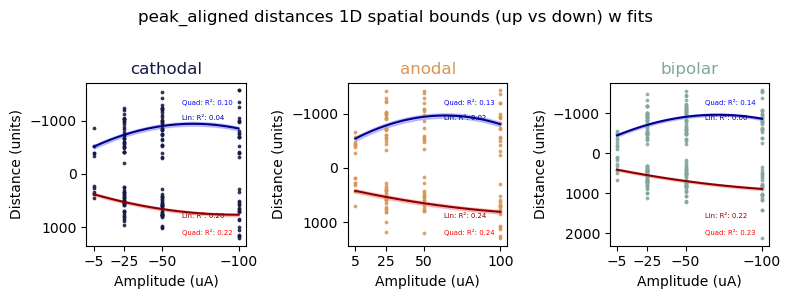

In [212]:
# ccf distances and peak aligned distances plots 
from scipy.stats import sem
from scipy.stats import linregress

for dist_type in ['ccf', 'peak_aligned']:
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # 2 rows for polarities, 2 columns for amplitude sign
    fig.suptitle(f'{dist_type} distances 1D spatial bounds (up vs down) w fits', fontsize=12)
    colors = [cathodal_color, anodal_color, bipolar_color]

    amps = [-5, -25, -50, -100]

    for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
        ax = axs[i]    
        ax.set_title(pol, color = colors[i])
        if pol == 'bipolar':
            polarity = 'bipolar'
        else:
            polarity = 'monopolar'
        
        all_upper_dists = []
        all_lower_dists = []
        all_amps = []
        
        for k, amp in enumerate(amps):
            
            if pol == 'anodal':
                amp = np.abs(amp)  # Make positive for anodal
        
            
            ax.set_xlabel('Amplitude (uA)')
            ax.set_ylabel('Distance (units)')
            ax.invert_yaxis()

            
            df = df_results[
                (df_results['max_volt'] > 40) &
                (df_results['amplitude'] == amp) &
                (df_results['polarity'] == polarity) &
                (df_results['half_max_lower_idx'] != -1) &
                (df_results['half_max_upper_idx'] != -1) &
                (df_results['lower_bound_idx'] != -1) &
                (df_results['upper_bound_idx'] != -1)
            ]
            if dist_type == 'ccf':
                upper_dists = df['upper_bound_dist'].values
                lower_dists = df['lower_bound_dist'].values
            elif dist_type == 'peak_aligned':
                normalized_distances = np.arange(-4000, 4000, 10)[::-1]
                upper_bound_idxs = df['upper_bound_idx_aligned'].values
                lower_bound_idxs = df['lower_bound_idx_aligned'].values
                upper_dists = [normalized_distances[idx] for idx in upper_bound_idxs]
                lower_dists = [normalized_distances[idx] for idx in lower_bound_idxs]
            
            # Collect data for scatter plot
            all_upper_dists.extend(upper_dists)
            all_lower_dists.extend(lower_dists)
            all_amps.extend([amp] * len(upper_dists))

            # Scatter individual data points
            ax.scatter([amp] * len(upper_dists), upper_dists, color=colors[i], s = 3,  alpha=0.8,  zorder=2)
            ax.scatter([amp] * len(lower_dists), lower_dists, color=colors[i], s = 3,  alpha=0.8, zorder=2)
        
            # print mean and std of upper and lower distances 
            mean_upper = np.mean(all_upper_dists)
            mean_lower = np.mean(all_lower_dists)
            std_upper = np.std(all_upper_dists)
            std_lower = np.std(all_lower_dists)
            print(f'{pol} {dist_type} {amp}uA: Upper Mean: {mean_upper:.2f}, Std: {std_upper:.2f}; Lower Mean: {mean_lower:.2f}, Std: {std_lower:.2f}')

        # Fit polynomial regression to the data
        if len(all_amps) > 1:  # Ensure we have enough data points
            upper_coeffs = np.polyfit(all_amps, all_upper_dists, deg=2)
            lower_coeffs = np.polyfit(all_amps, all_lower_dists, deg=2)
            upper_poly = np.poly1d(upper_coeffs)
            lower_poly = np.poly1d(lower_coeffs)

            # Generate smooth curves for plotting
            amp_range = np.linspace(np.min(all_amps), np.max(all_amps), 100)
            upper_fit = upper_poly(amp_range)
            lower_fit = lower_poly(amp_range)

            # Calculate standard error of the mean (SEM) for the fits
            upper_fit_err = sem(all_upper_dists)
            lower_fit_err = sem(all_lower_dists)

            # Plot polynomial regression lines
            ax.plot(amp_range, upper_fit, color='darkblue', label='Upper Bound Fit', zorder=4)
            ax.plot(amp_range, lower_fit, color='darkred', label='Lower Bound Fit', zorder=4)

            # Add error bands
            ax.fill_between(amp_range, upper_fit - upper_fit_err, upper_fit + upper_fit_err, color='blue', alpha=0.2, label='Upper Fit Error', zorder=1)
            ax.fill_between(amp_range, lower_fit - lower_fit_err, lower_fit + lower_fit_err, color='red', alpha=0.2, label='Lower Fit Error', zorder=1)
            
            x = all_amps
            y_upper = all_upper_dists
            y_lower = all_lower_dists

            # Linear fit (Upper)
            slope_u, intercept_u, r_u, pval_u, stderr_u = linregress(x, y_upper)
            r2_linear_upper = r_u ** 2
            print(f"Linear Fit (Upper): R² = {r2_linear_upper:.2f}, Slope = {slope_u:.2f}, Intercept = {intercept_u:.2f}, p = {pval_u:.2e}")

            # Quadratic fit (Upper)
            coeffs_quad_upper = np.polyfit(x, y_upper, 2)
            p_quad_upper = np.poly1d(coeffs_quad_upper)
            y_fit_quad_upper = p_quad_upper(x)
            r2_quad_upper = 1 - (np.sum((y_upper - y_fit_quad_upper)**2) / np.sum((y_upper - np.mean(y_upper))**2))
            print(f"Quadratic Fit (Upper): R² = {r2_quad_upper:.2f}, Coeffs = {coeffs_quad_upper}")

            # Linear fit (Lower)
            slope_l, intercept_l, r_l, pval_l, stderr_l = linregress(x, y_lower)
            r2_linear_lower = r_l ** 2
            print(f"Linear Fit (Lower): R² = {r2_linear_lower:.2f}, Slope = {slope_l:.2f}, Intercept = {intercept_l:.2f}, p = {pval_l:.2e}")

            # Quadratic fit (Lower)
            coeffs_quad_lower = np.polyfit(x, y_lower, 2)
            p_quad_lower = np.poly1d(coeffs_quad_lower)
            y_fit_quad_lower = p_quad_lower(x)
            r2_quad_lower = 1 - (np.sum((y_lower - y_fit_quad_lower)**2) / np.sum((y_lower - np.mean(y_lower))**2))
            print(f"Quadratic Fit (Lower): R² = {r2_quad_lower:.2f}, Coeffs = {coeffs_quad_lower}")
            # Add color-coded text annotations for R² values
            ax.text(
                0.6, 0.90,
                f"Quad: R²: {r2_quad_upper:.2f}",
                color='blue', fontsize=5, verticalalignment='top', transform=ax.transAxes
            )
            ax.text(
                0.6, 0.80,
                f"Lin: R²: {r2_linear_upper:.2f}",
                color='darkblue', fontsize=5, verticalalignment='top', transform=ax.transAxes
            )

            ax.text(
                0.6, 0.10,
                f"Quad: R²: {r2_quad_lower:.2f}",
                color='red', fontsize=5, verticalalignment='top', transform=ax.transAxes)
            ax.text(
                0.6, 0.20,
                f"Lin: R²: {r2_linear_lower:.2f}",
                color='darkred', fontsize=5, verticalalignment='top', transform=ax.transAxes)
            
        if pol == 'anodal':
            ax.set_xticks(np.abs(amps))
        else:
            ax.set_xticks(amps)
            ax.invert_xaxis() # Invert x-axis for negative amplitudes
        ax.invert_yaxis()
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
    #plt.savefig(os.path.join(path, f'distances_{dist_type}_with_fit_updated.png'))
    #plt.savefig(os.path.join(path, f'distances_{dist_type}_with_fit_updated.pdf'))



cathodal ccf -5uA: upper mean=-424.21, lower mean=510.41
cathodal ccf -25uA: upper mean=-724.96, lower mean=604.66
cathodal ccf -50uA: upper mean=-812.46, lower mean=747.08
cathodal ccf -100uA: upper mean=-750.41, lower mean=887.71
cathodal upper linear: R²=0.02, slope=1.21, p=2.10e-01
cathodal lower linear: R²=0.16, slope=-3.84, p=1.29e-04
anodal ccf 5uA: upper mean=-395.69, lower mean=502.02
anodal ccf 25uA: upper mean=-737.42, lower mean=733.93
anodal ccf 50uA: upper mean=-738.96, lower mean=762.47
anodal ccf 100uA: upper mean=-775.00, lower mean=890.74
anodal upper linear: R²=0.07, slope=-2.09, p=3.19e-02
anodal lower linear: R²=0.10, slope=2.99, p=9.08e-03
bipolar ccf -5uA: upper mean=-217.88, lower mean=385.22
bipolar ccf -25uA: upper mean=-731.20, lower mean=686.00
bipolar ccf -50uA: upper mean=-792.48, lower mean=773.15
bipolar ccf -100uA: upper mean=-756.91, lower mean=1042.26
bipolar upper linear: R²=0.05, slope=2.19, p=1.31e-02
bipolar lower linear: R²=0.17, slope=-5.47, p=4

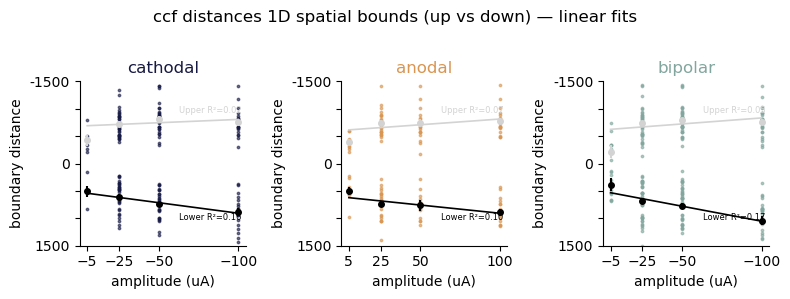

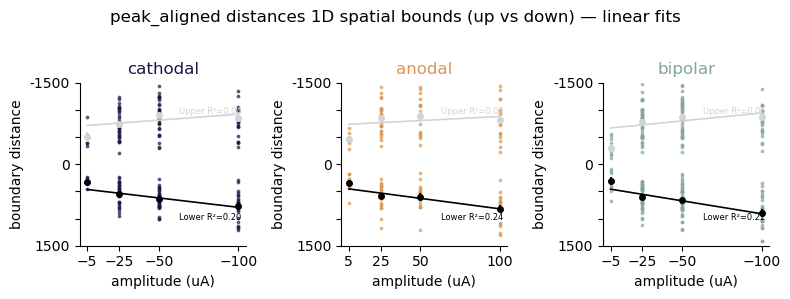

In [ ]:
# ccf distances and peak aligned distances plots 
from scipy.stats import sem, linregress

for dist_type in ['ccf', 'peak_aligned']:
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'{dist_type} distances 1D spatial bounds (up vs down) — linear fits', fontsize=12)
    colors = [cathodal_color, anodal_color, bipolar_color]

    amps = [-5, -25, -50, -100]

    for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
        ax = axs[i]
        ax.set_title(pol, color=colors[i])

        polarity = 'bipolar' if pol == 'bipolar' else 'monopolar'

        all_upper_dists = []
        all_lower_dists = []
        all_amps = []

        mean_upper_per_amp = []
        mean_lower_per_amp = []
        sem_upper_per_amp = []
        sem_lower_per_amp = []

        for k, amp in enumerate(amps):
            if pol == 'anodal':
                amp = np.abs(amp)

            df = df_results[
                (df_results['max_volt'] > 40) &
                (df_results['amplitude'] == amp) &
                (df_results['polarity'] == polarity) &
                (df_results['half_max_lower_idx'] != -1) &
                (df_results['half_max_upper_idx'] != -1) &
                (df_results['lower_bound_idx'] != -1) &
                (df_results['upper_bound_idx'] != -1)
            ]

            if dist_type == 'ccf':
                upper_dists = df['upper_bound_dist'].values
                lower_dists = df['lower_bound_dist'].values
            else:
                normalized_distances = np.arange(-4000, 4000, 10)[::-1]
                upper_dists = [normalized_distances[idx] for idx in df['upper_bound_idx_aligned'].values]
                lower_dists = [normalized_distances[idx] for idx in df['lower_bound_idx_aligned'].values]

            # scatter points
            ax.scatter([amp] * len(upper_dists), upper_dists, color=colors[i], s=3, alpha=0.6, zorder=2)
            ax.scatter([amp] * len(lower_dists), lower_dists, color=colors[i], s=3, alpha=0.6, zorder=2)

            # accumulate
            all_upper_dists.extend(upper_dists)
            all_lower_dists.extend(lower_dists)
            all_amps.extend([amp] * len(upper_dists))

            # store mean ± sem for plotting mean dots
            mean_upper_per_amp.append(np.mean(upper_dists))
            mean_lower_per_amp.append(np.mean(lower_dists))
            sem_upper_per_amp.append(sem(upper_dists))
            sem_lower_per_amp.append(sem(lower_dists))

            print(f'{pol} {dist_type} {amp}uA: upper mean={np.mean(upper_dists):.2f}, lower mean={np.mean(lower_dists):.2f}')

        # plot means with error bars
        ax.errorbar(amps if pol != 'anodal' else np.abs(amps),
                    mean_upper_per_amp, yerr=sem_upper_per_amp,
                    fmt='o', color='lightgray', markersize=4, label='upper mean', zorder=4)
        ax.errorbar(amps if pol != 'anodal' else np.abs(amps),
                    mean_lower_per_amp, yerr=sem_lower_per_amp,
                    fmt='o', color='black', markersize=4, label='lower mean', zorder=4)

        # linear fits
        if len(all_amps) > 1:
            x = np.asarray(all_amps)
            y_upper = np.asarray(all_upper_dists)
            y_lower = np.asarray(all_lower_dists)

            # linear regressions
            slope_u, intercept_u, r_u, p_u, _ = linregress(x, y_upper)
            slope_l, intercept_l, r_l, p_l, _ = linregress(x, y_lower)
            r2_u = r_u ** 2
            r2_l = r_l ** 2

            x_line = np.linspace(np.min(x), np.max(x), 100)
            ax.plot(x_line, slope_u * x_line + intercept_u, color='lightgray', linewidth=1.2)
            ax.plot(x_line, slope_l * x_line + intercept_l, color='black', linewidth=1.2)

            print(f"{pol} upper linear: R²={r2_u:.2f}, slope={slope_u:.2f}, p={p_u:.2e}")
            print(f"{pol} lower linear: R²={r2_l:.2f}, slope={slope_l:.2f}, p={p_l:.2e}")

            # annotate
            ax.text(0.60, 0.85, f"Upper R²={r2_u:.2f}", color='lightgray', fontsize=6, va='top', transform=ax.transAxes)
            ax.text(0.60, 0.20, f"Lower R²={r2_l:.2f}", color='black', fontsize=6, va='top', transform=ax.transAxes)

        # aesthetics
        if pol == 'anodal':
            ax.set_xticks(np.abs(amps))
        else:
            ax.set_xticks(amps)
            ax.invert_xaxis()

        ax.set_xlabel('amplitude (uA)')
        ax.set_ylabel('boundary distance')
        
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.invert_yaxis()
        ax.set_ylim([1500, -1500])
        ax.set_yticks([1500, 1000, 500, 0, -500, -1000, -1500], ['1500', '', '', '0', '', '', '-1500'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
    # plt.savefig(os.path.join(path, f'distances_{dist_type}_linear_means.png'))
    # plt.savefig(os.path.join(path, f'distances_{dist_type}_linear_means.pdf'))


cathodal ccf: upper R²=0.02, lower R²=0.16
anodal ccf: upper R²=0.07, lower R²=0.12
bipolar ccf: upper R²=0.04, lower R²=0.16
cathodal peak_aligned: upper R²=0.04, lower R²=0.20
anodal peak_aligned: upper R²=0.02, lower R²=0.24
bipolar peak_aligned: upper R²=0.06, lower R²=0.22


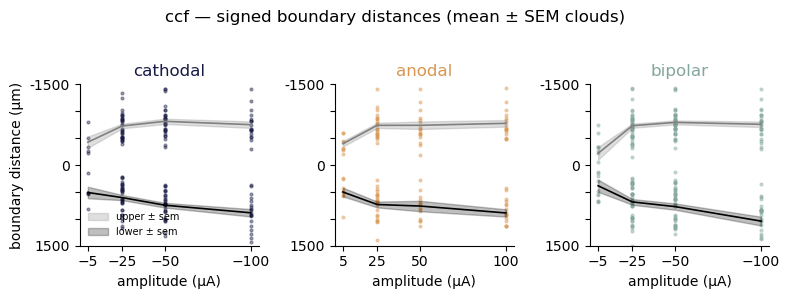

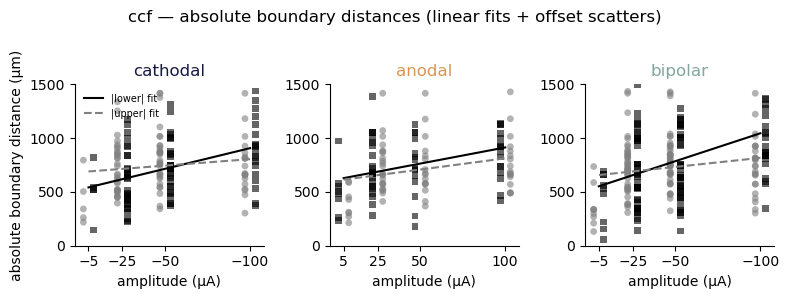

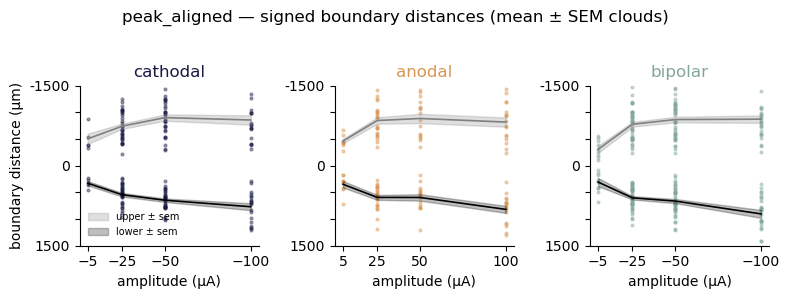

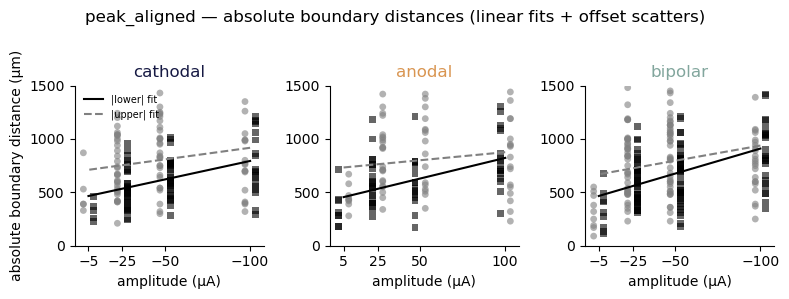

In [33]:
# full version: signed means ± SEM (clouds) and absolute linear fits (offset scatters)
from scipy.stats import sem, linregress

for dist_type in ['ccf', 'peak_aligned']:
    colors = [cathodal_color, anodal_color, bipolar_color]
    amps_base = [-5, -25, -50, -100]

    # ========== PLOT 1: signed means ± SEM as error "clouds" with individual points ==========
    fig1, axs1 = plt.subplots(1, 3, figsize=(8, 3))
    fig1.suptitle(f'{dist_type} — signed boundary distances (mean ± SEM clouds)', fontsize=12)

    for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
        ax = axs1[i]
        ax.set_title(pol, color=colors[i])
        polarity = 'bipolar' if pol == 'bipolar' else 'monopolar'
        amps = np.abs(amps_base) if pol == 'anodal' else amps_base

        mean_upper, mean_lower = [], []
        sem_upper, sem_lower = [], []

        for amp_in in amps_base:
            amp = abs(amp_in) if pol == 'anodal' else amp_in
            df = df_results[
                (df_results['max_volt'] > 40) &
                (df_results['amplitude'] == amp) &
                (df_results['polarity'] == polarity) &
                (df_results['half_max_lower_idx'] != -1) &
                (df_results['half_max_upper_idx'] != -1) &
                (df_results['lower_bound_idx'] != -1) &
                (df_results['upper_bound_idx'] != -1)
            ]
            if dist_type == 'ccf':
                upper_dists = df['upper_bound_dist'].values
                lower_dists = df['lower_bound_dist'].values
            else:
                normalized_distances = np.arange(-4000, 4000, 10)[::-1]
                upper_dists = [normalized_distances[idx] for idx in df['upper_bound_idx_aligned'].values]
                lower_dists = [normalized_distances[idx] for idx in df['lower_bound_idx_aligned'].values]

            ax.scatter([amp]*len(upper_dists), upper_dists, color=colors[i], s=4, alpha=0.4, zorder=1)
            ax.scatter([amp]*len(lower_dists), lower_dists, color=colors[i], s=4, alpha=0.4, zorder=1)

            mean_upper.append(np.mean(upper_dists))
            mean_lower.append(np.mean(lower_dists))
            sem_upper.append(sem(upper_dists))
            sem_lower.append(sem(lower_dists))

        # shaded SEM "clouds"
        ax.plot(amps, mean_upper, color='gray', lw=1.2)
        ax.fill_between(amps,
                        np.array(mean_upper)-np.array(sem_upper),
                        np.array(mean_upper)+np.array(sem_upper),
                        color='gray', alpha=0.25, label='upper ± sem')
        ax.plot(amps, mean_lower, color='black', lw=1.2)
        ax.fill_between(amps,
                        np.array(mean_lower)-np.array(sem_lower),
                        np.array(mean_lower)+np.array(sem_lower),
                        color='black', alpha=0.25, label='lower ± sem')

        # formatting
        if pol == 'anodal':
            ax.set_xticks(np.abs(amps_base))
        else:
            ax.set_xticks(amps_base)
            ax.invert_xaxis()
        ax.set_xlabel('amplitude (µA)')
        if i == 0:
            ax.set_ylabel('boundary distance (µm)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.invert_yaxis()
        ax.set_ylim([1500, -1500])
        ax.set_yticks([1500, 1000, 500, 0, -500, -1000, -1500],
                      ['1500', '', '', '0', '', '', '-1500'])
        if i == 0:
            ax.legend(frameon=False, fontsize=7, loc='lower left')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig(os.path.join(path, f'{dist_type}_means_sem_cloud.png'))
    #plt.savefig(os.path.join(path, f'{dist_type}_means_sem_cloud.pdf'))


    # ========== PLOT 2: absolute distances with linear fits + offset scatters ==========
    fig2, axs2 = plt.subplots(1, 3, figsize=(8, 3))
    fig2.suptitle(f'{dist_type} — absolute boundary distances (linear fits + offset scatters)', fontsize=12)

    offset = 3.0  # µA offset between upper and lower scatters

    for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
        ax = axs2[i]
        ax.set_title(pol, color=colors[i])
        polarity = 'bipolar' if pol == 'bipolar' else 'monopolar'
        amps = np.abs(amps_base) if pol == 'anodal' else amps_base

        x_upper, y_upper = [], []
        x_lower, y_lower = [], []

        for amp_in in amps_base:
            amp = abs(amp_in) if pol == 'anodal' else amp_in
            df = df_results[
                (df_results['max_volt'] > 40) &
                (df_results['amplitude'] == amp) &
                (df_results['polarity'] == polarity) &
                (df_results['half_max_lower_idx'] != -1) &
                (df_results['half_max_upper_idx'] != -1) &
                (df_results['lower_bound_idx'] != -1) &
                (df_results['upper_bound_idx'] != -1)
            ]
            if dist_type == 'ccf':
                upper_dists = df['upper_bound_dist'].values
                lower_dists = df['lower_bound_dist'].values
            else:
                normalized_distances = np.arange(-4000, 4000, 10)[::-1]
                upper_dists = [normalized_distances[idx] for idx in df['upper_bound_idx_aligned'].values]
                lower_dists = [normalized_distances[idx] for idx in df['lower_bound_idx_aligned'].values]

            au = np.abs(upper_dists)
            al = np.abs(lower_dists)

            x_upper.extend([amp]*len(au))
            y_upper.extend(au)
            x_lower.extend([amp]*len(al))
            y_lower.extend(al)

            # offset scatter positions
            ax.scatter(np.array([amp]*len(au)) + offset, au,
                       marker='o', s=24, color='gray', alpha=0.6, edgecolor='none', zorder=2, label=None)
            ax.scatter(np.array([amp]*len(al)) - offset, al,
                       marker='s', s=24, color='black', alpha=0.6, edgecolor='none', zorder=2, label=None)

        # regression fits
        if len(x_upper) > 1 and len(x_lower) > 1:
            xu, yu = np.array(x_upper, float), np.array(y_upper, float)
            xl, yl = np.array(x_lower, float), np.array(y_lower, float)
            su, bu, ru, pu, _ = linregress(xu, yu)
            sl, bl, rl, pl, _ = linregress(xl, yl)
            x_line = np.linspace(np.min(amps), np.max(amps), 100)
            ax.plot(x_line, sl * x_line + bl, color='black', lw=1.5, ls='-', label='|lower| fit')
            ax.plot(x_line, su * x_line + bu, color='gray', lw=1.5, ls='--', label='|upper| fit')
            print(f"{pol} {dist_type}: upper R²={ru**2:.2f}, lower R²={rl**2:.2f}")

        if pol == 'anodal':
            ax.set_xticks(np.abs(amps_base))
        else:
            ax.set_xticks(amps_base)
            ax.invert_xaxis()
        ax.set_xlabel('amplitude (µA)')
        if i == 0:
            ax.set_ylabel('absolute boundary distance (µm)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0, 1500)
        ax.set_yticks([0, 500, 1000, 1500])
        if i == 0:
            ax.legend(frameon=False, fontsize=7, loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
    #plt.savefig(os.path.join(path, f'{dist_type}_abs_linear_fit_offset.png'))
    #plt.savefig(os.path.join(path, f'{dist_type}_abs_linear_fit_offset.pdf'))


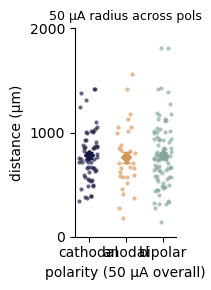

In [41]:
# config
dist_type = 'ccf'   # 'ccf' or 'peak_aligned'
title = f'50 µA radius across pols'

# helper: pull combined absolute distances (upper + lower) at 50 µA for one polarity
def _pull_combined_50(df_results, dist_type, pol_name):
    # map to df polarity/amp
    if pol_name == 'bipolar':
        polarity = 'bipolar'; amp = -50
    elif pol_name == 'anodal':
        polarity = 'monopolar'; amp = 50
    else:
        polarity = 'monopolar'; amp = -50  # cathodal

    df = df_results[
        (df_results['max_volt'] > 40) &
        (df_results['amplitude'] == amp) &
        (df_results['polarity'] == polarity) &
        (df_results['half_max_lower_idx'] != -1) &
        (df_results['half_max_upper_idx'] != -1) &
        (df_results['lower_bound_idx'] != -1) &
        (df_results['upper_bound_idx'] != -1)
    ].copy()

    # get distances per side
    if dist_type == 'ccf':
        upper = df['upper_bound_dist'].to_numpy(dtype=float)
        lower = df['lower_bound_dist'].to_numpy(dtype=float)
    else:  # 'peak_aligned'
        # aligned distances are in 10 µm steps from -4000..+3990 reversed
        normalized_distances = np.arange(-4000, 4000, 10)[::-1]
        upper = np.array([normalized_distances[idx] for idx in df['upper_bound_idx_aligned'].to_numpy()], dtype=float)
        lower = np.array([normalized_distances[idx] for idx in df['lower_bound_idx_aligned'].to_numpy()], dtype=float)

    # combine as magnitudes; n doubles (upper+lower treated as separate observations)
    pooled = np.concatenate([np.abs(upper), np.abs(lower)])
    return pooled

# build tidy df
rows = []
for pol in ['cathodal', 'anodal', 'bipolar']:
    vals = _pull_combined_50(df_results, dist_type, pol)
    rows += [{'polarity': pol, 'dist_abs': v} for v in vals]
plot_df = pd.DataFrame(rows)

# plot: strip + mean±sem in your stim colors
fig, ax = plt.subplots(figsize=(2, 3.0))
ax.set_title(title, fontsize=9)
ax.set_xlabel('polarity (50 µA overall)')
ax.set_ylabel('distance (µm)')

for pol, col in [('cathodal', cathodal_color), ('anodal', anodal_color), ('bipolar', bipolar_color)]:
    sub = plot_df[plot_df['polarity'] == pol]
    sns.stripplot(
        data=sub, x='polarity', y='dist_abs',
        jitter=0.25, alpha=0.65, size=3,
        color=col, ax=ax
    )

# overlay mean ± sem
g = plot_df.groupby('polarity')['dist_abs']
xcats = ['cathodal', 'anodal', 'bipolar']
xlocs = np.arange(len(xcats))
means = [g.get_group(cat).mean() for cat in xcats]
sems  = [g.get_group(cat).sem()  for cat in xcats]
for xi, cat, m, s in zip(xlocs, xcats, means, sems):
    ax.errorbar(
        xi, m, yerr=s, fmt='D-', lw=1.2, ms=5,
        color={'cathodal': cathodal_color, 'anodal': anodal_color, 'bipolar': bipolar_color}[cat],
        capsize=3, zorder=3
    )
ax.set_yticks([0, 1000, 2000])
# styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# optional fixed ylim for comparability:
# ax.set_ylim(0, 1500)

plt.tight_layout()
path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
#plt.savefig(os.path.join(path, f'ccf_dist_50ua_avgdist.png'))
#plt.savefig(os.path.join(path, f'ccf_dist_50ua_avgdist.pdf'))


In [179]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Filter for valid ccf entries
df_ccf = df_results[
    (df_results['max_volt'] > 40) &
    (df_results['half_max_lower_idx'] != -1) &
    (df_results['half_max_upper_idx'] != -1) &
    (df_results['lower_bound_idx'] != -1) &
    (df_results['upper_bound_idx'] != -1) &
    (df_results['amplitude'] != 10) &
    (df_results['amplitude'] != -10)  # Exclude 10 uA
]

# Build long-form dataframe
records = []

for _, row in df_ccf.iterrows():
    for bound_type, dist_col in zip(['upper', 'lower'], ['upper_bound_dist', 'lower_bound_dist']):
            records.append({
                'distance': row[dist_col],
                'amplitude': np.abs(row['amplitude']),
                'polarity': (
                    'bipolar' if row['polarity'] == 'bipolar'
                    else 'anodal' if row['amplitude'] > 0
                    else 'cathodal'
                ),
            'bound_type': bound_type
        })

df_long = pd.DataFrame(records)
df_long['amplitude'] = df_long['amplitude'].astype('category')
df_long['polarity'] = df_long['polarity'].astype('category')
df_long['bound_type'] = df_long['bound_type'].astype('category')


for bound in ['upper', 'lower']:
    print(f"\n---- {bound.upper()} BOUND ----")
    df_bound = df_long[df_long['bound_type'] == bound]
    
    model = ols('distance ~ C(polarity) * amplitude', data=df_bound).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

model = ols('distance ~ C(polarity) * amplitude * C(bound_type)', data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


---- UPPER BOUND ----
                             sum_sq     df          F        PR(>F)
C(polarity)            2.612212e+04    2.0   0.198274  8.202461e-01
amplitude              5.192329e+06    3.0  26.274122  3.257599e-15
C(polarity):amplitude  1.826601e+05    6.0   0.462146  8.361307e-01
Residual               2.101374e+07  319.0        NaN           NaN

---- LOWER BOUND ----
                             sum_sq     df          F        PR(>F)
C(polarity)            3.553331e+05    2.0   1.605160  2.024754e-01
amplitude              4.696354e+06    3.0  14.143348  1.120115e-08
C(polarity):amplitude  2.112106e+05    6.0   0.318037  9.273975e-01
Residual               3.530840e+07  319.0        NaN           NaN
                                           sum_sq     df            F  \
C(polarity)                          2.861572e+05    2.0     1.620751   
amplitude                            1.328851e+06    3.0     5.017607   
C(bound_type)                        3.569065e+08    1.

In [177]:
# Treat amplitude as continuous — make sure it's numeric
df_cathodal['amplitude'] = df_cathodal['amplitude'].astype(float)

# Run model with continuous amplitude and interaction with bound_type
model = ols('distance ~ amplitude * C(bound_type)', data=df_cathodal).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                               sum_sq     df            F        PR(>F)
C(bound_type)            9.015774e+07    1.0  1283.646767  5.029399e-80
amplitude                2.669355e+05    1.0     3.800570  5.292023e-02
amplitude:C(bound_type)  9.794379e+05    1.0    13.945028  2.584006e-04
Residual                 1.165912e+07  166.0          NaN           NaN


# half spatial extents superficial and deep (Figure 2g and Supp CCF vs peak-aligned)

cathodal ccf -5uA: Upper Mean: 31.49, Std: 301.06; Lower Mean: 302.57, Std: 234.81
cathodal ccf -25uA: Upper Mean: -283.79, Std: 281.54; Lower Mean: 328.18, Std: 244.42
cathodal ccf -50uA: Upper Mean: -300.85, Std: 279.61; Lower Mean: 339.96, Std: 227.53
cathodal ccf -100uA: Upper Mean: -279.71, Std: 286.84; Lower Mean: 355.71, Std: 232.71
anodal ccf 5uA: Upper Mean: -134.92, Std: 220.61; Lower Mean: 319.43, Std: 192.13
anodal ccf 25uA: Upper Mean: -306.78, Std: 264.31; Lower Mean: 395.94, Std: 231.47
anodal ccf 50uA: Upper Mean: -300.52, Std: 260.12; Lower Mean: 391.61, Std: 251.56
anodal ccf 100uA: Upper Mean: -301.87, Std: 269.74; Lower Mean: 410.17, Std: 257.40
bipolar ccf -5uA: Upper Mean: -79.96, Std: 307.77; Lower Mean: 238.04, Std: 244.85
bipolar ccf -25uA: Upper Mean: -272.31, Std: 313.09; Lower Mean: 337.11, Std: 288.38
bipolar ccf -50uA: Upper Mean: -309.26, Std: 324.47; Lower Mean: 346.61, Std: 315.59
bipolar ccf -100uA: Upper Mean: -296.00, Std: 332.25; Lower Mean: 373.29,

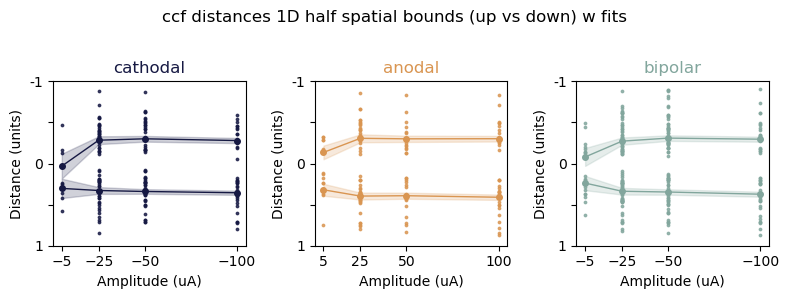

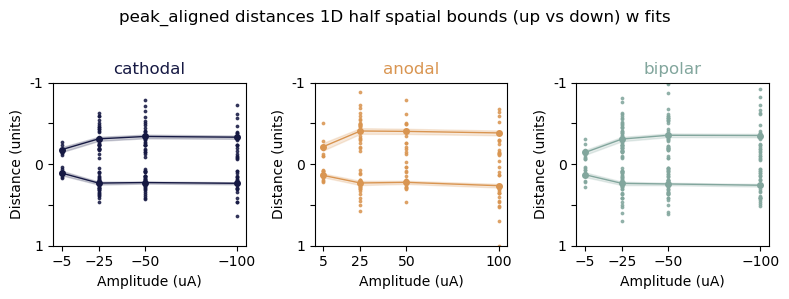

In [34]:
# ccf distances and peak aligned distances plots 
from scipy.stats import sem


for dist_type in ['ccf', 'peak_aligned']:
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # 2 rows for polarities, 2 columns for amplitude sign
    fig.suptitle(f'{dist_type} distances 1D half spatial bounds (up vs down) w fits', fontsize=12)
    colors = [cathodal_color, anodal_color, bipolar_color]

    

    for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
        ax = axs[i]    
        ax.set_title(pol, color = colors[i])
        if pol == 'bipolar':
            polarity = 'bipolar'
        else:
            polarity = 'monopolar'
        
        all_upper_dists = []
        all_lower_dists = []
        all_amps = []
        
        all_mean_uppers = []
        all_mean_lowers = []
        all_std_uppers = []
        all_std_lowers = []
        all_sem_uppers = []
        all_sem_lowers = []
        amps = [-5, -25, -50, -100]
        for k, amp in enumerate(amps):
            
            if pol == 'anodal':
                amp = np.abs(amp)  # Make positive for anodal
        
            
            ax.set_xlabel('Amplitude (uA)')
            ax.set_ylabel('Distance (units)')
            #ax.invert_yaxis()

            
            df = df_results[
                (df_results['max_volt'] > 40) &
                (df_results['amplitude'] == amp) &
                (df_results['polarity'] == polarity) &
                (df_results['half_max_lower_idx'] != -1) &
                (df_results['half_max_upper_idx'] != -1) &
                (df_results['lower_bound_idx'] != -1) &
                (df_results['upper_bound_idx'] != -1)
            ]
            if dist_type == 'ccf':
                upper_dists = df['half_max_upper_dist'].values
                lower_dists = df['half_max_lower_dist'].values
            elif dist_type == 'peak_aligned':
                normalized_distances = np.arange(-4000, 4000, 10)[::-1]
                upper_bound_idxs = df['half_max_upper_idx_aligned'].values
                lower_bound_idxs = df['half_max_lower_idx_aligned'].values
                upper_dists = [normalized_distances[idx] for idx in upper_bound_idxs]
                lower_dists = [normalized_distances[idx] for idx in lower_bound_idxs]
            
            # Collect data for scatter plot
            all_upper_dists.extend(upper_dists)
            all_lower_dists.extend(lower_dists)
            all_amps.extend([amp] * len(upper_dists))

            # Scatter individual data points
            ax.scatter([amp] * len(upper_dists), upper_dists, color=colors[i], s = 3,  alpha=0.8,  zorder=2)
            ax.scatter([amp] * len(lower_dists), lower_dists, color=colors[i], s = 3,  alpha=0.8, zorder=2)
            
            # print mean and std of upper and lower distances 
            mean_upper = np.mean(all_upper_dists)
            mean_lower = np.mean(all_lower_dists)
            std_upper = np.std(all_upper_dists)
            std_lower = np.std(all_lower_dists)
            sem_upper = sem(all_upper_dists)
            sem_lower = sem(all_lower_dists)
            
            all_mean_uppers.append(mean_upper)
            all_mean_lowers.append(mean_lower)
            all_std_uppers.append(std_upper)
            all_std_lowers.append(std_lower)
            all_sem_uppers.append(sem_upper)
            all_sem_lowers.append(sem_lower)
            
            print(f'{pol} {dist_type} {amp}uA: Upper Mean: {mean_upper:.2f}, Std: {std_upper:.2f}; Lower Mean: {mean_lower:.2f}, Std: {std_lower:.2f}')
        
        
        if pol == 'anodal':
            amps = [5, 25, 50, 100]
        else:
            amps = [-5, -25, -50, -100]
        ax.plot(amps, all_mean_uppers, color = colors[i], marker = 'o', markersize = 4, linewidth = 1)
        ax.plot(amps, all_mean_lowers, color = colors[i], marker = 'o', markersize = 4, linewidth = 1)
        ax.fill_between(amps, 
                        np.array(all_mean_uppers) - np.array(all_sem_uppers),
                        np.array(all_mean_uppers) + np.array(all_sem_uppers),
                        color=colors[i], alpha=0.2, label='Upper Bound SEM', zorder=1)
        ax.fill_between(amps,
                        np.array(all_mean_lowers) - np.array(all_sem_lowers),
                        np.array(all_mean_lowers) + np.array(all_sem_lowers),
                        color=colors[i], alpha=0.2, label='Lower Bound SEM', zorder=1)
        
            

        # Fit polynomial regression to the data
        if len(all_amps) > 1:  # Ensure we have enough data points
            upper_coeffs = np.polyfit(all_amps, all_upper_dists, deg=2)
            lower_coeffs = np.polyfit(all_amps, all_lower_dists, deg=2)
            upper_poly = np.poly1d(upper_coeffs)
            lower_poly = np.poly1d(lower_coeffs)

            # Generate smooth curves for plotting
            amp_range = np.linspace(np.min(all_amps), np.max(all_amps), 100)
            upper_fit = upper_poly(amp_range)
            lower_fit = lower_poly(amp_range)

            # Calculate standard error of the mean (SEM) for the fits
            upper_fit_err = sem(all_upper_dists)
            lower_fit_err = sem(all_lower_dists)

            # Plot polynomial regression lines
            #ax.plot(amp_range, upper_fit, color='darkblue', label='Upper Bound Fit', zorder=4)
            #ax.plot(amp_range, lower_fit, color='darkred', label='Lower Bound Fit', zorder=4)

            # Add error bands
            #ax.fill_between(amp_range, upper_fit - upper_fit_err, upper_fit + upper_fit_err, color='blue', alpha=0.2, label='Upper Fit Error', zorder=1)
            #ax.fill_between(amp_range, lower_fit - lower_fit_err, lower_fit + lower_fit_err, color='red', alpha=0.2, label='Lower Fit Error', zorder=1)
            
            x = all_amps
            y_upper = all_upper_dists
            y_lower = all_lower_dists

            # Fit linear regression for upper bounds
            coeffs_linear_upper = np.polyfit(x, y_upper, 1)
            p_linear_upper = np.poly1d(coeffs_linear_upper)
            y_fit_linear_upper = p_linear_upper(x)
            r2_linear_upper = 1 - (np.sum((y_upper - y_fit_linear_upper)**2) / np.sum((y_upper - np.mean(y_upper))**2))

            # Fit quadratic regression for upper bounds
            coeffs_quad_upper = np.polyfit(x, y_upper, 2)
            p_quad_upper = np.poly1d(coeffs_quad_upper)
            y_fit_quad_upper = p_quad_upper(x)
            r2_quad_upper = 1 - (np.sum((y_upper - y_fit_quad_upper)**2) / np.sum((y_upper - np.mean(y_upper))**2))

            # Fit linear regression for lower bounds
            coeffs_linear_lower = np.polyfit(x, y_lower, 1)
            p_linear_lower = np.poly1d(coeffs_linear_lower)
            y_fit_linear_lower = p_linear_lower(x)
            r2_linear_lower = 1 - (np.sum((y_lower - y_fit_linear_lower)**2) / np.sum((y_lower - np.mean(y_lower))**2))

            # Fit quadratic regression for lower bounds
            coeffs_quad_lower = np.polyfit(x, y_lower, 2)
            p_quad_lower = np.poly1d(coeffs_quad_lower)
            y_fit_quad_lower = p_quad_lower(x)
            r2_quad_lower = 1 - (np.sum((y_lower - y_fit_quad_lower)**2) / np.sum((y_lower - np.mean(y_lower))**2))

            # Add color-coded text annotations for R² values
            # Upper bounds
            #ax.text(
            #    0.6, 0.90,
            #    f"Quad: R²: {r2_quad_upper:.2f}",
            #    color='blue', fontsize=5, verticalalignment='top', transform=ax.transAxes
            #)
            #ax.text(
            #    0.6, 0.80,
            #    f"Lin: R²: {r2_linear_upper:.2f}",
            #    color='darkblue', fontsize=5, verticalalignment='top', transform=ax.transAxes
            #)

            #ax.text(
            #    0.6, 0.10,
            #    f"Quad: R²: {r2_quad_lower:.2f}",
            #    color='red', fontsize=5, verticalalignment='top', transform=ax.transAxes)
            #ax.text(
            #    0.6, 0.20,
            #    f"Lin: R²: {r2_linear_lower:.2f}",
            #    color='darkred', fontsize=5, verticalalignment='top', transform=ax.transAxes)
            
        if pol == 'anodal':
            ax.set_xticks(np.abs(amps))
        else:
            ax.set_xticks(amps)
            ax.invert_xaxis() # Invert x-axis for negative amplitudes
        #ax.invert_yaxis()
        ax.set_ylim([-1000, 1000])
        ax.set_yticks([1000, 500, 0, -500, -1000], ['1', '', '0', '', '-1'])
        ax.invert_yaxis()
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
    #plt.savefig(os.path.join(path, f'half_distances_{dist_type}_updated.png'))
    #plt.savefig(os.path.join(path, f'half_distances_{dist_type}_updated.pdf'))



In [269]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Filter for valid ccf entries
df_ccf = df_results[
    (df_results['max_volt'] > 40) &
    (df_results['half_max_lower_idx'] != -1) &
    (df_results['half_max_upper_idx'] != -1) &
    (df_results['lower_bound_idx'] != -1) &
    (df_results['upper_bound_idx'] != -1) &
    (df_results['amplitude'] != 10) &
    (df_results['amplitude'] != -10)  # Exclude 10 uA
]

# Build long-form dataframe
records = []

for _, row in df_ccf.iterrows():
    for bound_type, dist_col in zip(['upper', 'lower'], ['half_max_upper_idx_aligned', 'half_max_lower_idx_aligned']):
            records.append({
                'distance': normalized_distances[row[dist_col]],
                'amplitude': np.abs(row['amplitude']),
                'polarity': (
                    'bipolar' if row['polarity'] == 'bipolar'
                    else 'anodal' if row['amplitude'] > 0
                    else 'cathodal'
                ),
            'bound_type': bound_type
        })

df_long = pd.DataFrame(records)
df_long['amplitude'] = df_long['amplitude'].astype('category')
df_long['polarity'] = df_long['polarity'].astype('category')
df_long['bound_type'] = df_long['bound_type'].astype('category')


for bound in ['upper', 'lower']:
    print(f"\n---- {bound.upper()} BOUND ----")
    df_bound = df_long[df_long['bound_type'] == bound]
    
    model = ols('distance ~ C(polarity) * amplitude', data=df_bound).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

model = ols('distance ~ C(polarity) * amplitude * C(bound_type)', data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


---- UPPER BOUND ----
                             sum_sq     df         F    PR(>F)
C(polarity)            1.710831e+05    2.0  1.794320  0.167914
amplitude              1.063893e+06    3.0  7.438742  0.000079
C(polarity):amplitude  2.610655e+05    6.0  0.912685  0.485872
Residual               1.520786e+07  319.0       NaN       NaN

---- LOWER BOUND ----
                             sum_sq     df          F        PR(>F)
C(polarity)            4.546873e+04    2.0   1.026404  3.594731e-01
amplitude              7.730928e+05    3.0  11.634454  2.959573e-07
C(polarity):amplitude  9.148992e+04    6.0   0.688427  6.591300e-01
Residual               7.065697e+06  319.0        NaN           NaN
                                           sum_sq     df            F  \
C(polarity)                          2.303527e+04    2.0     0.329909   
amplitude                            4.379313e+05    3.0     4.181344   
C(bound_type)                        6.077392e+07    1.0  1740.798057   
C(polar

In [268]:
6.040685e-03

0.006040685

In [258]:
df.columns

Index(['recording', 'probe', 'run', 'stim_parameters', 'max_idx', 'max_volt',
       'half_max', 'half_max_upper_idx', 'half_max_lower_idx',
       'lower_bound_idx', 'upper_bound_idx', 'mean_gauss', 'std_gauss',
       'mean_aligned_sub_data', 'amplitude', 'polarity', 'sub_polarity',
       'aligned_mean_gauss', 'aligned_chs', 'half_max_upper_idx_aligned',
       'half_max_lower_idx_aligned', 'lower_bound_idx_aligned',
       'upper_bound_idx_aligned', 'half_max_AUC', 'full_AUC',
       'half_max_upper_dist', 'half_max_lower_dist', 'upper_bound_dist',
       'lower_bound_dist'],
      dtype='object')

cathodal ccf -5uA: Upper Mean: -424.21, Std: 209.65; Lower Mean: 510.41, Std: 214.59
cathodal ccf -25uA: Upper Mean: -683.18, Std: 252.64; Lower Mean: 591.57, Std: 261.42
cathodal ccf -50uA: Upper Mean: -741.94, Std: 267.22; Lower Mean: 662.26, Std: 263.13
cathodal ccf -100uA: Upper Mean: -743.84, Std: 264.17; Lower Mean: 712.65, Std: 286.44
anodal ccf 5uA: Upper Mean: -395.69, Std: 134.43; Lower Mean: 502.02, Std: 213.57
anodal ccf 25uA: Upper Mean: -649.23, Std: 254.65; Lower Mean: 674.08, Std: 266.56
anodal ccf 50uA: Upper Mean: -679.78, Std: 263.20; Lower Mean: 704.17, Std: 310.94
anodal ccf 100uA: Upper Mean: -705.07, Std: 262.35; Lower Mean: 753.73, Std: 312.35
bipolar ccf -5uA: Upper Mean: -217.88, Std: 337.07; Lower Mean: 385.22, Std: 320.11
bipolar ccf -25uA: Upper Mean: -640.61, Std: 331.39; Lower Mean: 632.92, Std: 355.58
bipolar ccf -50uA: Upper Mean: -709.20, Std: 301.83; Lower Mean: 696.25, Std: 372.51
bipolar ccf -100uA: Upper Mean: -719.62, Std: 292.95; Lower Mean: 771.

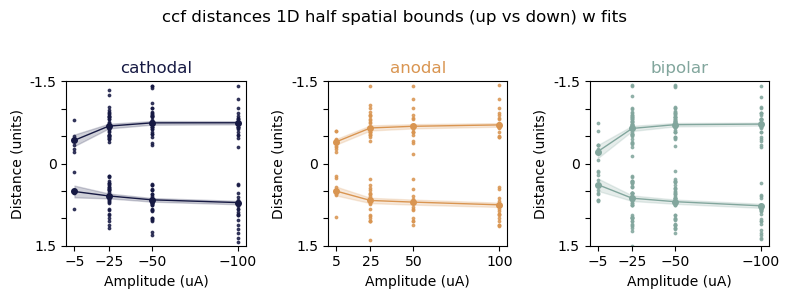

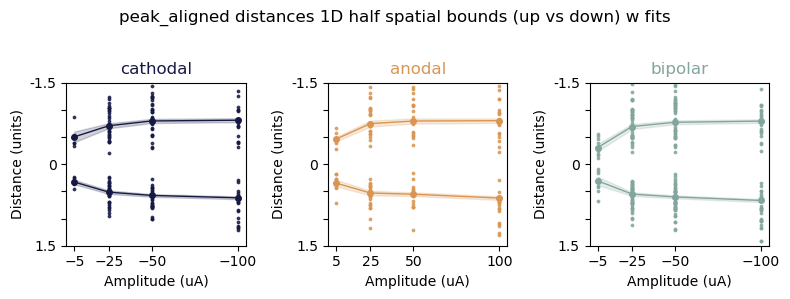

In [264]:
# ccf distances and peak aligned distances plots 
from scipy.stats import sem


for dist_type in ['ccf', 'peak_aligned']:
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # 2 rows for polarities, 2 columns for amplitude sign
    fig.suptitle(f'{dist_type} distances 1D half spatial bounds (up vs down) w fits', fontsize=12)
    colors = [cathodal_color, anodal_color, bipolar_color]

    

    for i, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
        ax = axs[i]    
        ax.set_title(pol, color = colors[i])
        if pol == 'bipolar':
            polarity = 'bipolar'
        else:
            polarity = 'monopolar'
        
        all_upper_dists = []
        all_lower_dists = []
        all_amps = []
        
        all_mean_uppers = []
        all_mean_lowers = []
        all_std_uppers = []
        all_std_lowers = []
        all_sem_uppers = []
        all_sem_lowers = []
        amps = [-5, -25, -50, -100]
        for k, amp in enumerate(amps):
            
            if pol == 'anodal':
                amp = np.abs(amp)  # Make positive for anodal
        
            
            ax.set_xlabel('Amplitude (uA)')
            ax.set_ylabel('Distance (units)')
            #ax.invert_yaxis()

            
            df = df_results[
                (df_results['max_volt'] > 40) &
                (df_results['amplitude'] == amp) &
                (df_results['polarity'] == polarity) &
                (df_results['half_max_lower_idx'] != -1) &
                (df_results['half_max_upper_idx'] != -1) &
                (df_results['lower_bound_idx'] != -1) &
                (df_results['upper_bound_idx'] != -1)
            ]
            if dist_type == 'ccf':
                upper_dists = df['upper_bound_dist'].values
                lower_dists = df['lower_bound_dist'].values
            elif dist_type == 'peak_aligned':
                normalized_distances = np.arange(-4000, 4000, 10)[::-1]
                upper_bound_idxs = df['upper_bound_idx_aligned'].values
                lower_bound_idxs = df['lower_bound_idx_aligned'].values
                upper_dists = [normalized_distances[idx] for idx in upper_bound_idxs]
                lower_dists = [normalized_distances[idx] for idx in lower_bound_idxs]
            
            # Collect data for scatter plot
            all_upper_dists.extend(upper_dists)
            all_lower_dists.extend(lower_dists)
            all_amps.extend([amp] * len(upper_dists))

            # Scatter individual data points
            ax.scatter([amp] * len(upper_dists), upper_dists, color=colors[i], s = 3,  alpha=0.8,  zorder=2)
            ax.scatter([amp] * len(lower_dists), lower_dists, color=colors[i], s = 3,  alpha=0.8, zorder=2)
            
            # print mean and std of upper and lower distances 
            mean_upper = np.mean(all_upper_dists)
            mean_lower = np.mean(all_lower_dists)
            std_upper = np.std(all_upper_dists)
            std_lower = np.std(all_lower_dists)
            sem_upper = sem(all_upper_dists)
            sem_lower = sem(all_lower_dists)
            
            all_mean_uppers.append(mean_upper)
            all_mean_lowers.append(mean_lower)
            all_std_uppers.append(std_upper)
            all_std_lowers.append(std_lower)
            all_sem_uppers.append(sem_upper)
            all_sem_lowers.append(sem_lower)
            
            print(f'{pol} {dist_type} {amp}uA: Upper Mean: {mean_upper:.2f}, Std: {std_upper:.2f}; Lower Mean: {mean_lower:.2f}, Std: {std_lower:.2f}')
        
        
        if pol == 'anodal':
            amps = [5, 25, 50, 100]
        else:
            amps = [-5, -25, -50, -100]
        ax.plot(amps, all_mean_uppers, color = colors[i], marker = 'o', markersize = 4, linewidth = 1)
        ax.plot(amps, all_mean_lowers, color = colors[i], marker = 'o', markersize = 4, linewidth = 1)
        ax.fill_between(amps, 
                        np.array(all_mean_uppers) - np.array(all_sem_uppers),
                        np.array(all_mean_uppers) + np.array(all_sem_uppers),
                        color=colors[i], alpha=0.2, label='Upper Bound SEM', zorder=1)
        ax.fill_between(amps,
                        np.array(all_mean_lowers) - np.array(all_sem_lowers),
                        np.array(all_mean_lowers) + np.array(all_sem_lowers),
                        color=colors[i], alpha=0.2, label='Lower Bound SEM', zorder=1)
        
            

        # Fit polynomial regression to the data
        if len(all_amps) > 1:  # Ensure we have enough data points
            upper_coeffs = np.polyfit(all_amps, all_upper_dists, deg=2)
            lower_coeffs = np.polyfit(all_amps, all_lower_dists, deg=2)
            upper_poly = np.poly1d(upper_coeffs)
            lower_poly = np.poly1d(lower_coeffs)

            # Generate smooth curves for plotting
            amp_range = np.linspace(np.min(all_amps), np.max(all_amps), 100)
            upper_fit = upper_poly(amp_range)
            lower_fit = lower_poly(amp_range)

            # Calculate standard error of the mean (SEM) for the fits
            upper_fit_err = sem(all_upper_dists)
            lower_fit_err = sem(all_lower_dists)

            # Plot polynomial regression lines
            #ax.plot(amp_range, upper_fit, color='darkblue', label='Upper Bound Fit', zorder=4)
            #ax.plot(amp_range, lower_fit, color='darkred', label='Lower Bound Fit', zorder=4)

            # Add error bands
            #ax.fill_between(amp_range, upper_fit - upper_fit_err, upper_fit + upper_fit_err, color='blue', alpha=0.2, label='Upper Fit Error', zorder=1)
            #ax.fill_between(amp_range, lower_fit - lower_fit_err, lower_fit + lower_fit_err, color='red', alpha=0.2, label='Lower Fit Error', zorder=1)
            
            x = all_amps
            y_upper = all_upper_dists
            y_lower = all_lower_dists

            # Fit linear regression for upper bounds
            coeffs_linear_upper = np.polyfit(x, y_upper, 1)
            p_linear_upper = np.poly1d(coeffs_linear_upper)
            y_fit_linear_upper = p_linear_upper(x)
            r2_linear_upper = 1 - (np.sum((y_upper - y_fit_linear_upper)**2) / np.sum((y_upper - np.mean(y_upper))**2))

            # Fit quadratic regression for upper bounds
            coeffs_quad_upper = np.polyfit(x, y_upper, 2)
            p_quad_upper = np.poly1d(coeffs_quad_upper)
            y_fit_quad_upper = p_quad_upper(x)
            r2_quad_upper = 1 - (np.sum((y_upper - y_fit_quad_upper)**2) / np.sum((y_upper - np.mean(y_upper))**2))

            # Fit linear regression for lower bounds
            coeffs_linear_lower = np.polyfit(x, y_lower, 1)
            p_linear_lower = np.poly1d(coeffs_linear_lower)
            y_fit_linear_lower = p_linear_lower(x)
            r2_linear_lower = 1 - (np.sum((y_lower - y_fit_linear_lower)**2) / np.sum((y_lower - np.mean(y_lower))**2))

            # Fit quadratic regression for lower bounds
            coeffs_quad_lower = np.polyfit(x, y_lower, 2)
            p_quad_lower = np.poly1d(coeffs_quad_lower)
            y_fit_quad_lower = p_quad_lower(x)
            r2_quad_lower = 1 - (np.sum((y_lower - y_fit_quad_lower)**2) / np.sum((y_lower - np.mean(y_lower))**2))

            # Add color-coded text annotations for R² values
            # Upper bounds
            #ax.text(
            #    0.6, 0.90,
            #    f"Quad: R²: {r2_quad_upper:.2f}",
            #    color='blue', fontsize=5, verticalalignment='top', transform=ax.transAxes
            #)
            #ax.text(
            #    0.6, 0.80,
            #    f"Lin: R²: {r2_linear_upper:.2f}",
            #    color='darkblue', fontsize=5, verticalalignment='top', transform=ax.transAxes
            #)

            #ax.text(
            #    0.6, 0.10,
            #    f"Quad: R²: {r2_quad_lower:.2f}",
            #    color='red', fontsize=5, verticalalignment='top', transform=ax.transAxes)
            #ax.text(
            #    0.6, 0.20,
            #    f"Lin: R²: {r2_linear_lower:.2f}",
            #    color='darkred', fontsize=5, verticalalignment='top', transform=ax.transAxes)
            
        if pol == 'anodal':
            ax.set_xticks(np.abs(amps))
        else:
            ax.set_xticks(amps)
            ax.invert_xaxis() # Invert x-axis for negative amplitudes
        #ax.invert_yaxis()
        ax.set_ylim([-1500, 1500])
        ax.set_yticks([1500, 1000, 500, 0, -500, -1000,-1500], ['1.5', '', '', '0', '', '', '-1.5'])
        ax.invert_yaxis()
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
    #plt.savefig(os.path.join(path, f'distances_{dist_type}_updated.png'))
    #plt.savefig(os.path.join(path, f'distances_{dist_type}_updated.pdf'))



In [111]:
min_ch_list = []
for _, row in df_results.iterrows():
    recording  = row['recording']
    probe = row['probe']
    r = recording_map[recording]
    dists = distances[recording][probe]
    arg_min = np.argmin(np.abs(dists))
    min_ch_list.append(arg_min)
df_results['closest_ch_ccf'] = min_ch_list

c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 27.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


One-way ANOVA: F = 23.1621, p = 5.5225e-28
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2   meandiff p-adj   lower    upper   reject
------------------------------------------------------------
  jlh31       jlh32 -10.4008 0.0641 -21.0999   0.2983  False
  jlh31       jlh33  -0.4537    1.0 -13.4243  12.5168  False
  jlh31       jlh34  -1.8425 0.9999 -13.0603   9.3753  False
  jlh31       jlh39 -37.5258    0.0  -55.704 -19.3477   True
  jlh31       jlh40 -21.7053 0.0147 -41.0034  -2.4072   True
  jlh31       jlh48  23.5218    0.0  11.0692  35.9744   True
  jlh31     jlh49v1 -15.6592 0.7749 -45.2575  13.9392  False
  jlh31 jlh53concat  31.8075    0.0  14.9262  48.6888   True
  jlh32       jlh33   9.9471 0.2871  -2.9926  22.8867  False
  jlh32       jlh34   8.5583 0.2929  -2.6237  19.7404  False
  jlh32       jlh39  -27.125 0.0002 -45.2811  -8.9689   True
  jlh32       jlh40 -11.3045 0.6613 -30.5818   7.9728  False
  jlh32       jlh48  33.9226    0.0  21.50

c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 28.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 27.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jordan\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


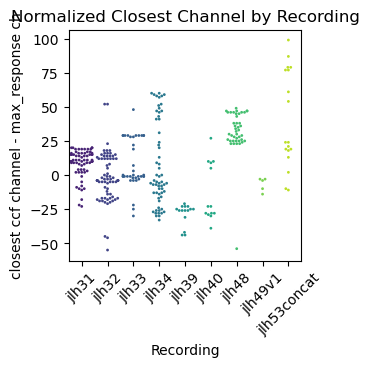

In [131]:
df = df_results.copy()
df = df[
            (df['max_volt'] > 40) & 
            (df['half_max_lower_idx'] != -1) &
            (df['half_max_upper_idx'] != -1) &
            (df['lower_bound_idx'] != -1) &
            (df['upper_bound_idx'] != -1)
        ].reset_index()

df['normalized_closest_ch'] = df['closest_ch_ccf'] - df['max_idx']

fig = plt.figure(figsize=(3, 3))
swarm_plot = sns.swarmplot(data=df, x='recording', y='normalized_closest_ch', hue = 'recording', palette='viridis', size = 2)

# Set labels with specified font size
plt.xlabel('Recording', fontsize=10)
plt.xticks(rotation=45)
plt.ylabel('closest ccf channel - max_response ch', fontsize=10)
plt.title('Normalized Closest Channel by Recording', fontsize=12)

#plt.savefig(os.path.join(path, 'normalized_closest_ch_by_recording.png'))
#plt.savefig(os.path.join(path, 'normalized_closest_ch_by_recording.pdf'))

from scipy.stats import f_oneway
# Make sure amplitude is treated as a group
grouped = df.groupby('recording')['normalized_closest_ch']

# Extract list of arrays (one per amplitude)
groups = [group.values for _, group in grouped]

# Run ANOVA
fval, pval = f_oneway(*groups)

print(f"One-way ANOVA: F = {fval:.4f}, p = {pval:.4e}")

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['normalized_closest_ch'],
                          groups=df['recording'],
                          alpha=0.05)

print(tukey.summary())

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\jordan\AppData\Local\Temp\ipykernel_35744\1624984870.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  swarm_plot = sns.swarmplot(data=df, x='amplitude', y='normalized_closest_ch', palette='viridis', s = 2)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


One-way ANOVA: F = 0.8836, p = 5.1956e-01


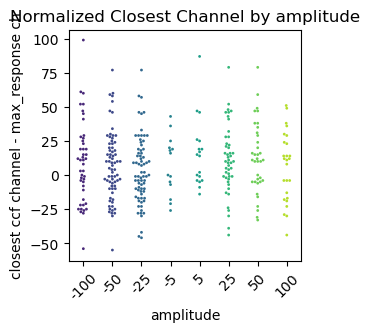

In [130]:
df = df_results.copy()
df = df[
            (df['max_volt'] > 40) & 
            (df['half_max_lower_idx'] != -1) &
            (df['half_max_upper_idx'] != -1) &
            (df['lower_bound_idx'] != -1) &
            (df['upper_bound_idx'] != -1) &
            (df['amplitude'] != 10) & 
            (df['amplitude'] != -10)
        ].reset_index()

df['normalized_closest_ch'] = df['closest_ch_ccf'] - df['max_idx']

fig = plt.figure(figsize = (3, 3))
swarm_plot = sns.swarmplot(data=df, x='amplitude', y='normalized_closest_ch', palette='viridis', s = 2)

# Set labels with specified font size
plt.xlabel('amplitude', fontsize=10)
plt.xticks(rotation=45)
plt.ylabel('closest ccf channel - max_response ch', fontsize=10)
plt.title('Normalized Closest Channel by amplitude', fontsize=12)


from scipy.stats import f_oneway
# Make sure amplitude is treated as a group
grouped = df.groupby('amplitude')['normalized_closest_ch']

# Extract list of arrays (one per amplitude)
groups = [group.values for _, group in grouped]

# Run ANOVA
fval, pval = f_oneway(*groups)

print(f"One-way ANOVA: F = {fval:.4f}, p = {pval:.4e}")

Mean normalized closest channel: 8.14, Std: 25.37 SEM: 1.39


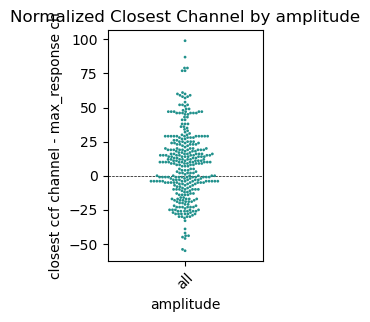

In [156]:
df = df_results.copy()
df = df[
            (df['max_volt'] > 40) & 
            (df['half_max_lower_idx'] != -1) &
            (df['half_max_upper_idx'] != -1) &
            (df['lower_bound_idx'] != -1) &
            (df['upper_bound_idx'] != -1)
        ].reset_index()

df['normalized_closest_ch'] = df['closest_ch_ccf'] - df['max_idx']

fig = plt.figure(figsize = (2, 3))
df['group'] = 'all'
swarm_plot = sns.swarmplot(data=df, x='group', y='normalized_closest_ch', hue = 'group',  palette='viridis', s = 2)

# Set labels with specified font size
plt.xlabel('amplitude', fontsize=10)
plt.xticks(rotation=45)
plt.ylabel('closest ccf channel - max_response ch', fontsize=10)
plt.title('Normalized Closest Channel by amplitude', fontsize=12)

# print the mean and std and sem of the normalized closest channel
mean_closest_ch = df['normalized_closest_ch'].mean()
std_closest_ch = df['normalized_closest_ch'].std()
sem_closest_ch = df['normalized_closest_ch'].sem()
print(f'Mean normalized closest channel: {mean_closest_ch:.2f}, Std: {std_closest_ch:.2f} SEM: {sem_closest_ch:.2f}')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'
#plt.savefig(os.path.join(path, 'normalized_closest_ch_all.png'))
#plt.savefig(os.path.join(path, 'normalized_closest_ch_all.pdf'))


# peak voltage, half and full AUC regressions for amplitudes

In [208]:
df.head()

,recording,probe,run,stim_parameters,max_idx,max_volt,half_max,half_max_upper_idx,half_max_lower_idx,lower_bound_idx,...,half_max_upper_idx_aligned,half_max_lower_idx_aligned,lower_bound_idx_aligned,upper_bound_idx_aligned,half_max_AUC,full_AUC,half_max_upper_dist,half_max_lower_dist,upper_bound_dist,lower_bound_dist
0,jlh31,probeA,0,"amp: -25 ua, pw: 100 us, contacts: 16r_2b",123,54.988943,27.494471,170,52,22,...,447,329,299,458,4679.986692,5702.399165,-393.883231,820.877579,-505.895246,1138.256122
2,jlh31,probeA,2,"amp: -50 ua, pw: 100 us, contacts: 16r_2b",122,123.950754,61.975377,171,77,40,...,449,355,318,467,9064.809696,11288.498274,-399.443363,591.261364,-581.271021,938.870066
4,jlh31,probeA,4,"amp: -100 ua, pw: 100 us, contacts: 16r_2b",113,161.665679,80.832839,160,92,51,...,447,379,338,483,8474.709654,12383.661506,-318.084894,435.219485,-654.854946,865.060114
12,jlh31,probeA,12,"amp: -25 ua, pw: 100 us, contacts: 10r_7b",123,55.518560,27.759280,160,94,78,...,437,371,355,447,2711.894529,3320.848682,-318.084894,439.851111,-393.883231,590.364294
14,jlh31,probeA,14,"amp: -50 ua, pw: 100 us, contacts: 10r_7b",122,96.514499,48.257249,149,94,76,...,427,372,354,457,4100.585455,5719.579958,-233.343095,439.851111,-472.465872,587.218869


cathodal_-5: max_volt mean ± std: 110.67 ± 97.96
cathodal_-25: max_volt mean ± std: 197.25 ± 197.37
cathodal_-50: max_volt mean ± std: 353.50 ± 325.07
cathodal_-100: max_volt mean ± std: 527.01 ± 442.73
cathodal_-5: half_max_AUC mean ± std: 2010.57 ± 1087.18
cathodal_-25: half_max_AUC mean ± std: 7754.23 ± 6601.05
cathodal_-50: half_max_AUC mean ± std: 12041.29 ± 7500.67
cathodal_-100: half_max_AUC mean ± std: 16399.46 ± 10677.75
cathodal_-5: full_AUC mean ± std: 3671.25 ± 1415.66
cathodal_-25: full_AUC mean ± std: 12496.41 ± 10821.99
cathodal_-50: full_AUC mean ± std: 21597.75 ± 13512.18
cathodal_-100: full_AUC mean ± std: 31915.49 ± 22758.19
anodal_5: max_volt mean ± std: 110.52 ± 114.66
anodal_25: max_volt mean ± std: 263.91 ± 227.95
anodal_50: max_volt mean ± std: 437.06 ± 336.55
anodal_100: max_volt mean ± std: 341.46 ± 277.31
anodal_5: half_max_AUC mean ± std: 2221.17 ± 1371.37
anodal_25: half_max_AUC mean ± std: 13506.90 ± 10289.11
anodal_50: half_max_AUC mean ± std: 19312.99 ± 

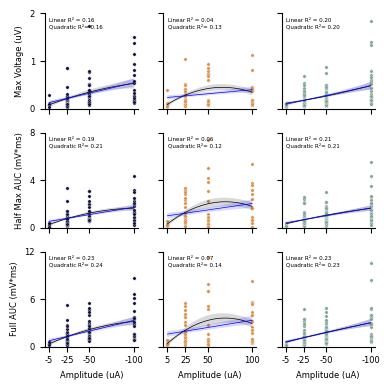

In [239]:
#scatters

fig, axs = plt.subplots(3, 3, figsize=(4, 4))
amplitudes = [-5, -25, -50, -100]

for col, pol in enumerate(['cathodal', 'anodal', 'bipolar']):
    if pol == 'bipolar':
        polarity = 'bipolar'
    else:
        polarity = 'monopolar'
    
    if pol == 'anodal':
        amps = np.abs(amplitudes)
    else:
        amps = amplitudes

    
    df = df_results[
        (df_results['max_volt'] > 40) & 
        (df_results['amplitude'].isin(amps)) & 
        (df_results['polarity'] == polarity) &
        (df_results['half_max_lower_idx'] != -1) &
        (df_results['half_max_upper_idx'] != -1) &
        (df_results['lower_bound_idx'] != -1) &
        (df_results['upper_bound_idx'] != -1)
    ]


    variables = ['max_volt', 'half_max_AUC', 'full_AUC']
    titles = ['Max Voltage by Amplitude', 'Half Max AUC by Amplitude', 'Full AUC by Amplitude']


    for i, (var, title) in enumerate(zip(variables, titles)):
        row = i
        ax = axs[row, col]
        

        
        # Scatter plot of individual points
        sns.scatterplot(
            data=df, x='amplitude', y=var, color = colors[col], s=6, ax=ax, legend=False, alpha=1
        )

        # fit first and second order regression lines style
        sns.regplot(
            data=df, x='amplitude', y=var, scatter=False, ci=68, order = 2, line_kws={'color': 'black', 'linewidth': 0.5}, ax=ax
        )
        
        sns.regplot(
            data=df, x='amplitude', y=var, scatter=False, ci=68, order = 1, line_kws={'color': 'blue', 'linewidth': 0.5}, ax=ax
        )
        
        # print mean and std of the variables 
        for amp in [-5, -25, -50, -100]:
            if pol == 'anodal':
                amp = np.abs(amp)
            amp_df = df[df['amplitude'] == amp]
            mean_value = amp_df[var].mean()
            std_value = amp_df[var].std()
            print(f'{pol}_{amp}: {var} mean ± std: {mean_value:.2f} ± {std_value:.2f}')
        

        #if row == 0:
            #ax.set_title(title, fontsize=6)
        if row == 2:
            ax.set_xlabel('Amplitude (uA)', fontsize=6) 
            ax.set_xticks(amps, amps,  fontsize = 6)
        else:
            ax.set_xlabel('')
            ax.set_xticks(amps, ['', '', '', ''], fontsize = 6)
        filtered_df = df[['amplitude', var]].dropna()
        x = filtered_df['amplitude']
        y = filtered_df[var]
            
        # Fit linear regression (order=1)
        coeffs_linear = np.polyfit(x, y, 1)
        p_linear = np.poly1d(coeffs_linear)
        y_fit_linear = p_linear(x)
        r2_linear = 1 - (np.sum((y - y_fit_linear)**2) / np.sum((y - np.mean(y))**2))
        
        # Fit quadratic regression (order=2)
        coeffs_quad = np.polyfit(x, y, 2)
        p_quad = np.poly1d(coeffs_quad)
        y_fit_quad = p_quad(x)
        r2_quad = 1 - (np.sum((y - y_fit_quad)**2) / np.sum((y - np.mean(y))**2))
        
        ax.text(0.05, 0.95, f"Linear R² = {r2_linear:.2f}\nQuadratic R²= {r2_quad:.2f}",
            transform=ax.transAxes, fontsize=4, verticalalignment='top')
        if pol != 'anodal':
            ax.invert_xaxis()
        
        if var == 'max_volt':
            ax.set_ylim([0, 2000])
            
            if col == 0:
                ax.set_ylabel('Max Voltage (uV)', fontsize=6)
                ax.set_yticks([0, 1000, 2000], [0, 1, 2], fontsize = 6)
            else:
                ax.set_ylabel('')
                ax.set_yticks([0, 1000, 2000], ['', '', ''], fontsize = 6)     
        elif var == 'half_max_AUC':
            ax.set_ylim([0, 80000])
            if col == 0:
                ax.set_ylabel('Half Max AUC (mV*ms)', fontsize=6)
                ax.set_yticks([0, 40000, 80000], [0, 4, 8], fontsize = 6)
            else:
                ax.set_ylabel('')
                ax.set_yticks([0, 40000, 80000], ['', '', ''], fontsize = 6)     
        elif var == 'full_AUC':
            ax.set_ylim([0, 120000])
            if col == 0:
                ax.set_yticks([0, 60000, 120000], [0, 6, 12], fontsize = 6)
                ax.set_ylabel('Full AUC (mV*ms)', fontsize=6)
            else:
                ax.set_yticks([0, 60000, 120000], ['', '', ''], fontsize = 6)
                ax.set_ylabel('')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Adjust layout and save the figure
    #plt.suptitle()

plt.tight_layout()
#plt.savefig(os.path.join(path, f'max_auc_scatter_with_means__poly_updated.png'))
#plt.savefig(os.path.join(path, f'max_auc_scatter_with_means__poly_updated.pdf'))

# comparing LFP and AP

confirming stream name: ProbeB-AP
confirming stream name: ProbeB-LFP


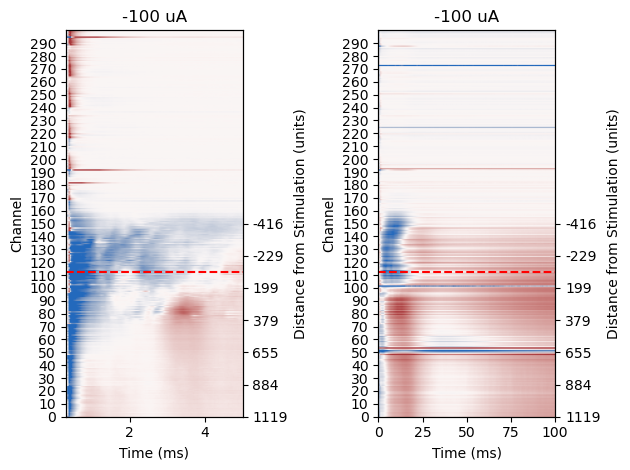

In [62]:
r = jlh31
probe = 'probeB'
amp = -100
channels = 300


stim_times = choose_stim_parameter(r.trials, amp=amp, pulse_number=1, pulse_duration=100, polarity='monopolar')[0:75]
fig, axes = plt.subplots(1,2)
## AP plot
pre = -0.3
post = 5 


data = r.raw.get_chunk(probe, stim_times, pre=pre + 3, post=post + 3, chs=np.arange(channels))
aligned_data = align_data(data, pre, post, channels, threshold=500, median_subtraction=False)

dists = distances[r.mouse][probe]

# Use the axs object for the current amp
sub_chs = np.arange(len(dists), len(dists) + 20)
aligned_sub_data = aligned_data - np.median(aligned_data[:,:, sub_chs], axis=2)[:,:, np.newaxis]

ax = axes[0]
raw_heatmap(aligned_sub_data, pre=pre, post=post, dists=dists, vmin=-300, vmax=300,
            save=False, title=f'{amp} uA', ax=ax)




# LFP 
pre = 0
post = 100

data = r.raw.get_chunk(probe, stim_times, pre=pre, post=post, band = 'lfp', chs=np.arange(channels))
aligned_data = data
dists = distances[r.mouse][probe]

# Use the axs object for the current amp
sub_chs = np.arange(len(dists), len(dists) + 40)
aligned_sub_data = aligned_data - np.median(aligned_data[:,:, sub_chs], axis=2)[:,:, np.newaxis]

ax = axes[1]
raw_heatmap(aligned_sub_data, pre=pre, post=post, dists=dists, vmin=-800, vmax=800,
            save=False, title=f'{amp} uA', ax=ax)

plt.tight_layout()

# volumes

In [202]:
from scipy.spatial import ConvexHull
import numpy as np

def calculate_volume(points):
    """
    Calculate the volume of a 3D shape defined by 6 points using a convex hull.
    
    Parameters:
        points (ndarray): A (6, 3) numpy array where each row represents a 3D point (x, y, z).
        
    Returns:
        float: The volume of the convex hull enclosing the points.
    """
    # Check if the input is valid
    if points.shape != (6, 3):
        raise ValueError("Input must be a (6, 3) array of 3D points.")
    
    # Compute the convex hull
    hull = ConvexHull(points) # points should be (6,3) array
    volume = hull.volume
    
    # Return the volume of the convex hull
    return hull.volume

In [203]:
#3D stuff... this requires measurements for all 3 probes...

polarities = ['bipolar', 'monopolar']

probes = ['probeA', 'probeB', 'probeC']
amps = [-5, -25, -50, -100, 5, 25, 50, 100]

volume_dict = {}
points_dict = {}
points_dict_rec = {}
rec_dict = {}

for polarity in polarities:
    for i, amp in enumerate(amps):
        # Filter data for the current probe and amplitude
        df = df_results[
            (df_results['max_volt'] > 40) & 
            (df_results['amplitude'] == amp) & 
            (df_results['polarity'] == polarity) &
            (df_results['lower_bound_idx'] != -1) &
            (df_results['upper_bound_idx'] != -1)
        ]
        #print(df['recording'].unique())
        for record in df['recording'].unique():
            probes = df[df['recording'] == record]['probe'].unique()
            if len(probes) == 3:
                key = f'{polarity}_{amp}'
                r = recording_map[record]
                a_df = df[(df['recording'] == record) & (df['probe'] == 'probeA')]
                a_upper_ch = a_df['upper_bound_idx'].values[0]
                a_lower_ch = a_df['lower_bound_idx'].values[0]
                try:
                    a_up_ccf = r.probe_coords['probeA'][a_upper_ch]
                except:
                    a_up_cff = r.probe_coords['probeA'][-1]
                    
                a_low_ccf = r.probe_coords['probeA'][a_lower_ch]
                
                b_df = df[(df['recording'] == record) & (df['probe'] == 'probeB')]
                b_upper_ch = b_df['upper_bound_idx'].values[0]
                b_lower_ch = b_df['lower_bound_idx'].values[0]
                
                try: 
                    b_up_ccf = r.probe_coords['probeB'][b_upper_ch]
                except:
                    b_up_ccf = r.probe_coords['probeB'][-1]
                b_low_ccf = r.probe_coords['probeB'][b_lower_ch]
                
                c_df = df[(df['recording'] == record) & (df['probe'] == 'probeC')]
                c_upper_ch = c_df['upper_bound_idx'].values[0]
                c_lower_ch = c_df['lower_bound_idx'].values[0]
                try:
                    c_up_ccf = r.probe_coords['probeC'][c_upper_ch]
                except:
                    c_up_ccf = r.probe_coords['probeC'][-1]
                c_low_ccf = r.probe_coords['probeC'][c_lower_ch]
                
                points = np.array([a_up_ccf, a_low_ccf, b_up_ccf, b_low_ccf, c_up_ccf, c_low_ccf])
                hull = ConvexHull(points)
                volume = hull.volume 
                
                if key not in volume_dict:
                    volume_dict[key] = []
                volume_dict[key].append(volume)
                if key not in points_dict:
                    points_dict[key] = []
                points_dict[key].append(points)
                
                key_rec = f'{record}_{polarity}_{amp}'
                if key_rec not in points_dict_rec:
                    points_dict_rec[key_rec] = []
                points_dict_rec[key_rec].append(points)

                if key not in rec_dict:
                    rec_dict[key] = []
                rec_dict[key].append(record)


Cathodal Mean Volumes: -25uA: 0.31+/-0.20 mm³, -50uA: 0.43+/-0.19mm³, -100uA: 0.61+/-0.22 mm³


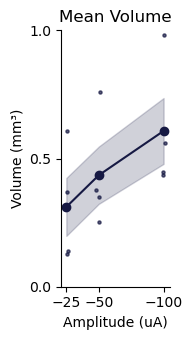

In [204]:
volume_dict_mm3 = {key: np.array(values) / 1e9 for key, values in volume_dict.items()}

mc_25 = volume_dict_mm3['monopolar_-25']
mc_50 = volume_dict_mm3['monopolar_-50']
mc_100 = volume_dict_mm3['monopolar_-100']

mc_x = [-25, -50, -100]
mc_y = [np.mean(mc_25), np.mean(mc_50), np.mean(mc_100)]
mc_err = [sem(mc_25), sem(mc_50), sem(mc_100)]
# print mean +/- std of monopolar volumes 
print(f'Cathodal Mean Volumes: -25uA: {np.mean(mc_25):.2f}+/-{np.std(mc_25):.2f} mm³, -50uA: {np.mean(mc_50):.2f}+/-{np.std(mc_50):.2f}mm³, -100uA: {np.mean(mc_100):.2f}+/-{np.std(mc_100):.2f} mm³')


fig, ax = plt.subplots(1, 1, figsize=(2, 3.5))

# Line and error fill for monopolar (cathodal)
ax.plot(mc_x, mc_y, label='Cathodal', color=cathodal_color, marker='o')
ax.fill_between(mc_x, np.array(mc_y) - np.array(mc_err), np.array(mc_y) + np.array(mc_err),
                color=cathodal_color, alpha=0.2)

# Plot individual values with jitter
jitter_strength = 1.1 
for x, values in zip(mc_x, [mc_25, mc_50, mc_100]):
    jittered_x = np.random.normal(x, scale=jitter_strength, size=len(values))
    ax.scatter(jittered_x, values, color=cathodal_color, s=5, alpha=0.7, zorder=3)

# Labels and formatting
ax.set_title('Mean Volume')
ax.set_xlabel('Amplitude (uA)')
ax.set_ylabel('Volume (mm³)')
ax.invert_xaxis()
ax.set_xticks([-25, -50, -100])
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

path = r'C:\Users\jordan\Documents\combined_figs\evoked_potentials'

#plt.savefig(os.path.join(path, 'monopolar_EPvolume.png'))
#plt.savefig(os.path.join(path, 'monopolar_EPvolume.pdf'))


In [153]:
from scipy.stats import linregress
import numpy as np

# Stack all individual volumes
all_volumes = np.concatenate([mc_25, mc_50, mc_100])
all_amplitudes = np.concatenate([
    np.full_like(mc_25, -25),
    np.full_like(mc_50, -50),
    np.full_like(mc_100, -100)
])

# Run linear regression
slope, intercept, r_value, p_value, std_err = linregress(np.abs(all_amplitudes), all_volumes)

# Print regression results
print(f"Linear Regression: Volume = {slope:.4f} * Amplitude + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}, p = {p_value:.4e}")


Linear Regression: Volume = 0.0039 * Amplitude + 0.2248
R² = 0.2591, p = 9.1036e-02


In [185]:
 9.1036e-02

0.091036

In [155]:
# Quadratic fit
quad_coeffs = np.polyfit(np.abs(all_amplitudes), all_volumes, deg=2)
quad_model = np.poly1d(quad_coeffs)

# Predicted values
y_quad_fit = quad_model(np.abs(all_amplitudes))

# R² for quadratic
ss_res_quad = np.sum((all_volumes - y_quad_fit) ** 2)
ss_tot = np.sum((all_volumes - np.mean(all_volumes)) ** 2)
r2_quad = 1 - (ss_res_quad / ss_tot)

print(f"Quadratic Fit: Volume = {quad_coeffs[0]:.4e} * A² + {quad_coeffs[1]:.4e} * A + {quad_coeffs[2]:.4e}")
print(f"R² (Quadratic) = {r2_quad:.4f}")


Quadratic Fit: Volume = -1.9901e-05 * A² + 6.4391e-03 * A + 1.6262e-01
R² (Quadratic) = 0.2614


Cathodal Mean Volumes: -25uA: 0.31+/-0.20 mm³, -50uA: 0.43+/-0.19mm³, -100uA: 0.61+/-0.22 mm³
Anodal Mean Volumes: 25uA: 0.39+/-0.15 mm³, 50uA: 0.55+/-0.28mm³, 100uA: 0.60+/-0.31 mm³
Bipolar Mean Volumes: -25uA: 0.41+/-0.18 mm³, -50uA: 0.35+/-0.17mm³, -100uA: 0.50+/-0.17 mm³


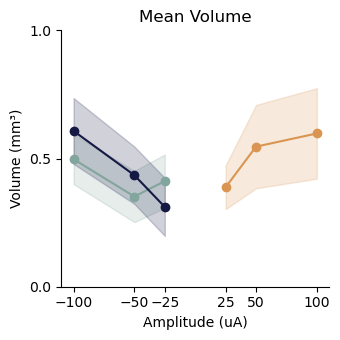

In [205]:
from scipy.stats import sem
# Convert µm³ to mm³ (1 mm³ = 10^9 µm³)
volume_dict_mm3 = {key: np.array(values) / 1e9 for key, values in volume_dict.items()}


bc_25 = volume_dict_mm3['bipolar_-25']
bc_50 = volume_dict_mm3['bipolar_-50']
bc_100 = volume_dict_mm3['bipolar_-100']

mc_25 = volume_dict_mm3['monopolar_-25']
mc_50 = volume_dict_mm3['monopolar_-50']
mc_100 = volume_dict_mm3['monopolar_-100']

ma_25 = volume_dict_mm3['monopolar_25']
ma_50 = volume_dict_mm3['monopolar_50']
ma_100 = volume_dict_mm3['monopolar_100']

bc_x = [-25, -50, -100]
bc_y = [np.mean(bc_25), np.mean(bc_50), np.mean(bc_100)]
bc_err = [sem(bc_25), sem(bc_50), sem(bc_100)]

mc_x = [-25, -50, -100]
mc_y = [np.mean(mc_25), np.mean(mc_50), np.mean(mc_100)]
mc_err = [sem(mc_25), sem(mc_50), sem(mc_100)]

ma_x = [25, 50, 100]
ma_y = [np.mean(ma_25), np.mean(ma_50), np.mean(ma_100)]
ma_err = [sem(ma_25), sem(ma_50), sem(ma_100)]

print(f'Cathodal Mean Volumes: -25uA: {np.mean(mc_25):.2f}+/-{np.std(mc_25):.2f} mm³, -50uA: {np.mean(mc_50):.2f}+/-{np.std(mc_50):.2f}mm³, -100uA: {np.mean(mc_100):.2f}+/-{np.std(mc_100):.2f} mm³')
print(f'Anodal Mean Volumes: 25uA: {np.mean(ma_25):.2f}+/-{np.std(ma_25):.2f} mm³, 50uA: {np.mean(ma_50):.2f}+/-{np.std(ma_50):.2f}mm³, 100uA: {np.mean(ma_100):.2f}+/-{np.std(ma_100):.2f} mm³')
print(f'Bipolar Mean Volumes: -25uA: {np.mean(bc_25):.2f}+/-{np.std(bc_25):.2f} mm³, -50uA: {np.mean(bc_50):.2f}+/-{np.std(bc_50):.2f}mm³, -100uA: {np.mean(bc_100):.2f}+/-{np.std(bc_100):.2f} mm³')

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# Bipolar
ax.plot(bc_x, bc_y, label='Bipolar', color=bipolar_color, marker='o')
ax.fill_between(bc_x, np.array(bc_y) - np.array(bc_err), np.array(bc_y) + np.array(bc_err), color=bipolar_color, alpha=0.2)

# Cathodal
ax.plot(mc_x, mc_y, label='Cathodal', color=cathodal_color, marker='o')
ax.fill_between(mc_x, np.array(mc_y) - np.array(mc_err), np.array(mc_y) + np.array(mc_err), color=cathodal_color, alpha=0.2)

# Anodal
ax.plot(ma_x, ma_y, label='Anodal', color=anodal_color, marker='o')
ax.fill_between(ma_x, np.array(ma_y) - np.array(ma_err), np.array(ma_y) + np.array(ma_err), color=anodal_color, alpha=0.2)

# Labels and legend
ax.set_title('Mean Volume')
ax.set_xlabel('Amplitude (uA)')
ax.set_ylabel('Volume (mm³)')
#ax.legend(loc='upper right')

ax.set_xticks([-100, -50, -25, 25, 50, 100])
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'volume_by_amplitude.png'))
#plt.savefig(os.path.join(path, 'volume_by_amplitude.pdf'))

In [186]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("volume ~ C(polarity) * amplitude", data=df_vol).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                         sum_sq    df         F    PR(>F)
C(polarity)            0.050685   2.0  0.416636  0.663427
amplitude              0.238417   2.0  1.959799  0.160418
C(polarity):amplitude  0.077475   4.0  0.318423  0.863128
Residual               1.642330  27.0       NaN       NaN
